# **Facial Emotion Detection**

## **Problem Definition**

**The context:** 
It is natural for a human to detect other's emotion by using facial expression, voice tone, and any other symptoms. However, it is difficult to identify emotion with just visual expression. It is still important to identify emotion because without knowing it, communication may be difficult or misleading. That is why to develop a good solution to detect facial emotion.<br>

**The objectives:** 
The goal is to train a model that can detect facial emotions with facial pictures.<br>

**The key questions:** 
What is the best algorithm that can identify facial emotion, and the hyperparameters to tune the algorithm?<br>

**The problem formulation:** 
Try different algorithms and measure the performance of the algorithms. 



## **About the dataset**

The data set consists of 3 folders, i.e., 'test', 'train', and 'validation'. 
Each of these folders has four subfolders:

**‘happy’**: Images of people who have happy facial expressions.<br>
**‘sad’**: Images of people with sad or upset facial expressions.<br>
**‘surprise’**: Images of people who have shocked or surprised facial expressions.<br>
**‘neutral’**: Images of people showing no prominent emotion in their facial expression at all.<br>


## **Mounting the Drive**

**NOTE:**  Please use Google Colab from your browser for this notebook. **Google.colab is NOT a library that can be downloaded locally on your device.**

In [1]:
# Because running the ML model takes longer time on google.colab, 
# the following codes will run on my laptop (Macbook Air M2)

# Mounting the drive
# from google.colab import drive
# drive.mount('/content/drive')

## **Importing the Libraries**

In [2]:
# import libraries for data manipulation
import numpy as np
import pandas as pd
import h5py as h5

# import libraries for data visualization
import matplotlib.pyplot as plt
import seaborn as sns

# import libraries for file handling
import os
import zipfile
from PIL import Image

# import libraries from sklearn
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import classification_report, confusion_matrix

# import tenserflow and its libraries
import tensorflow as tf

from tensorflow.keras.utils import load_img, img_to_array
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization, Conv2D, MaxPooling2D, Flatten, LeakyReLU
from tensorflow.keras.layers import Input, GlobalAveragePooling2D, Flatten, BatchNormalization, Activation
from tensorflow.keras.optimizers import Adam, SGD, RMSprop
from tensorflow.keras.applications import VGG16, ResNet50V2, EfficientNetB0
from tensorflow.keras import backend
from tensorflow.keras import optimizers


### **Let us load and unzip the data**

**Note:** 
- You must download the dataset from the link provided on Olympus and upload the same on your Google drive before executing the code in the next cell.
- In case of any error, please make sure that the path of the file is correct as the path may be different for you.

In [3]:
# Storing the path of the data file compressed into a zip file
dataset_file = './4.2.Facial_Emotion_Detection_Dataset.zip'

# The data is provided as a zip file so we need to extract the files from the zip file
with zipfile.ZipFile(dataset_file, 'r') as zip_ref:
    zip_ref.extractall()

## **Visualizing our Classes**

Let's look at our classes. 

**Write down your observation for each class. What do you think can be a unique feature of each emotion, that separates it from the remaining classes?**

In [4]:
# Define variables and functions for simplifying program
emotions = ['happy', 'neutral', 'sad', 'surprise']  
picture_size = 48
folder_path = "./Facial_Emotion_Images/"

# Define a function to display data images
def show_data_images(data_category, emotion):
    print("\nImages of " + emotion + " in the " + data_category + " folder")
    plt.figure(figsize = (10, 10))

    for i in range(1, 10, 1):
        plt.subplot(3, 3, i)
        img = load_img(folder_path + data_category + "/" + emotion + "/" +
                  os.listdir(folder_path + "train/" + emotion)[i], target_size = (picture_size, picture_size))
        plt.imshow(img)

    plt.show()

### **Happy**

**Observations and Insights:__**


Images of happy in the train folder


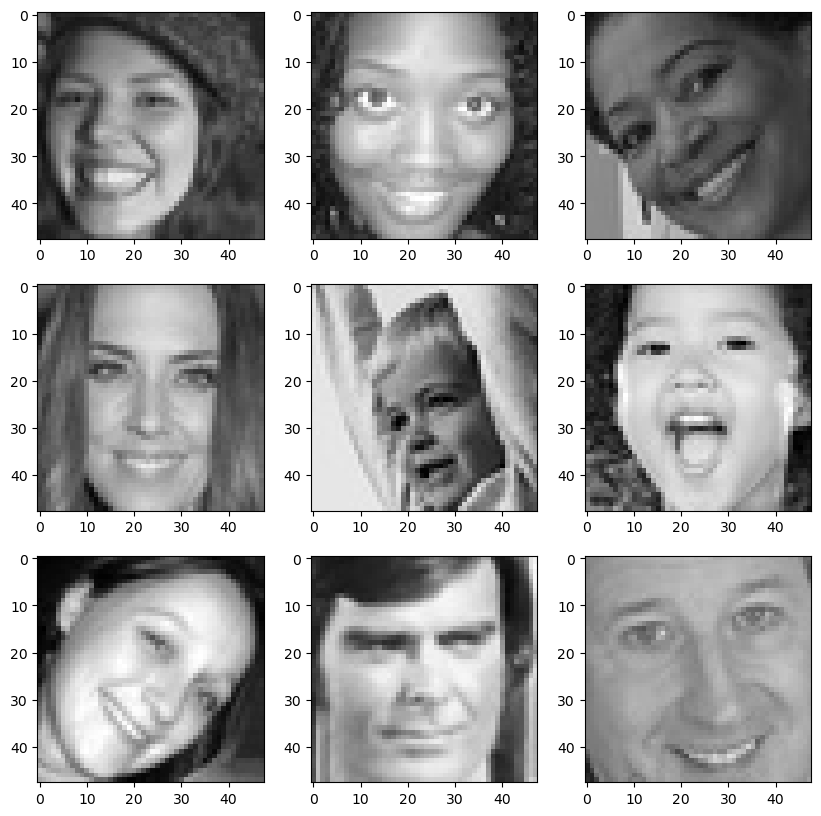


Images of neutral in the train folder


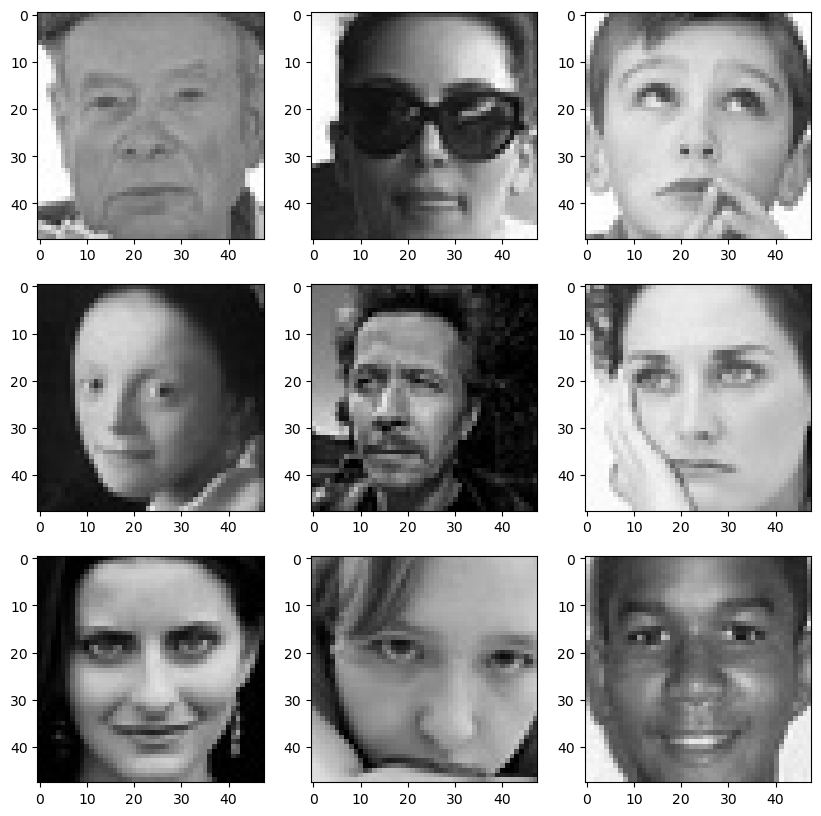


Images of sad in the train folder


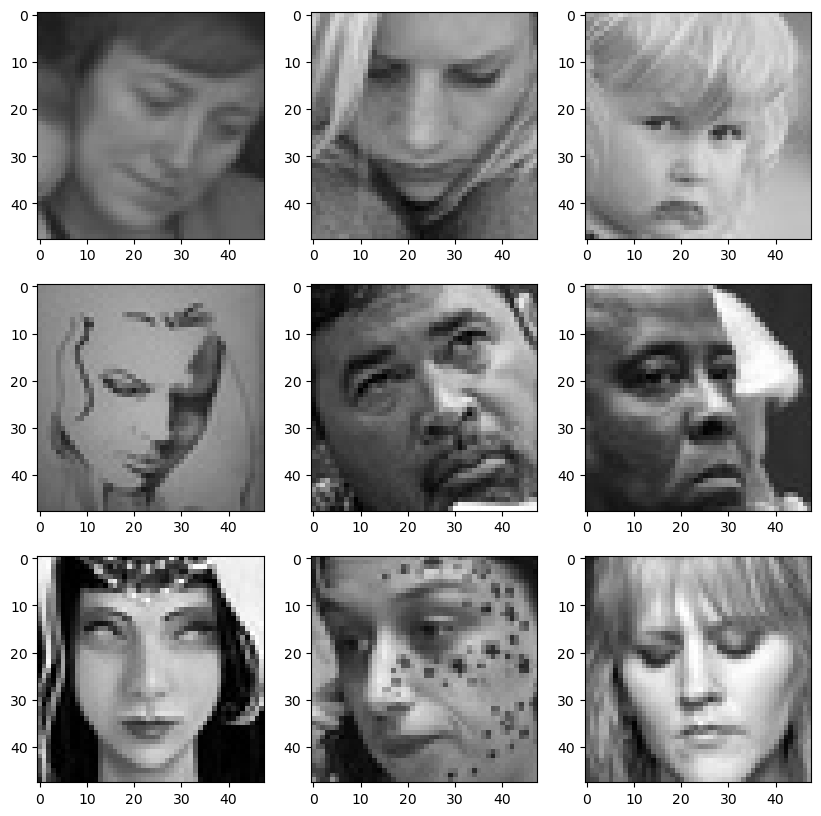


Images of surprise in the train folder


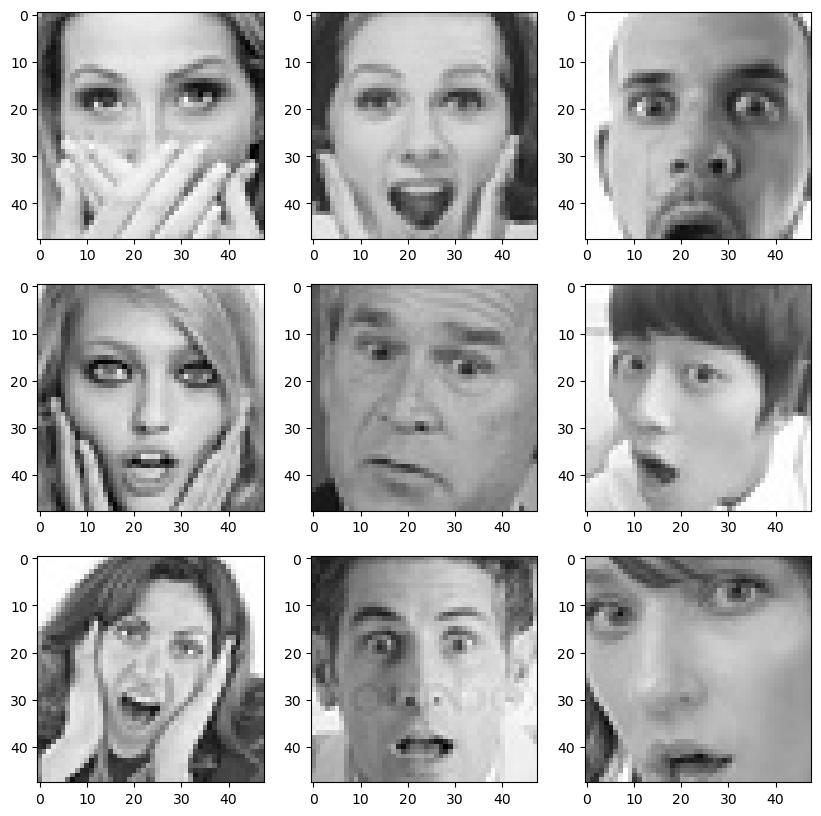

In [5]:
# Show data images of emtiones in 'train' folder

for emotion in emotions:
    show_data_images("train", emotion)

### **Sad**

**Observations and Insights:__**

### **Neutral**

**Observations and Insights:__**

### **Surprised**

**Observations and Insights:__**

## **Checking Distribution of Classes**

## **Creating our Data Loaders**

In this section, we are creating data loaders that we will use as inputs to our Neural Network.

**You have two options for the color_mode. You can set it to color_mode = 'rgb' or color_mode = 'grayscale'. You will need to try out both and see for yourself which one gives better performance.**

In [6]:
def loading_data(color_mode, resolution):
    batch_size  = 128

    datagen_train  = ImageDataGenerator()
    datagen_val = ImageDataGenerator()
    datagen_test = ImageDataGenerator()

    print("Load images of train dataset: ", end="")
    train_set = datagen_train.flow_from_directory(folder_path + 'train/',
                                                target_size = (resolution, resolution),
                                                color_mode = color_mode,
                                                batch_size = batch_size,
                                                class_mode = 'categorical',
                                                classes = emotions,
                                                shuffle = True)

    print("Load images of validation dataset: ", end="")
    validation_set = datagen_val.flow_from_directory(folder_path + 'validation/',
                                                target_size = (resolution, resolution),
                                                color_mode = color_mode,
                                                batch_size = batch_size,
                                                class_mode = 'categorical',
                                                classes = emotions,
                                                shuffle = True)

    print("Load images of test dataset: ", end="")
    test_set = datagen_test.flow_from_directory(folder_path + 'test/',
                                                target_size = (resolution, resolution),
                                                color_mode = color_mode,
                                                batch_size = batch_size,
                                                class_mode = 'categorical',
                                                classes = emotions,
                                                shuffle = True)
    return train_set, validation_set, test_set

train_set_g, validation_set_g, test_set_g = loading_data("grayscale", picture_size)
train_set_c, validation_set_c, test_set_c = loading_data("rgb", picture_size)


Load images of train dataset: Found 15109 images belonging to 4 classes.
Load images of validation dataset: Found 4977 images belonging to 4 classes.
Load images of test dataset: Found 128 images belonging to 4 classes.
Load images of train dataset: Found 15109 images belonging to 4 classes.
Load images of validation dataset: Found 4977 images belonging to 4 classes.
Load images of test dataset: Found 128 images belonging to 4 classes.


In [7]:
# Define a function that counts instances in each class. The classes are stored in labels, 
# so couting number of each labels will enable couting each classes

class_names = {}
for class_name, class_instance in train_set_g.class_indices.items():
    class_names[class_instance] = class_name

def check_class_instances(category, dataset):
    # get the labels of the instances
    labels = dataset.labels

    # count the number of instances in each class
    class_counts = {}
    for label in labels:
        if label not in class_counts:
            class_counts[label] = 0
        class_counts[label] += 1

    # Print the number of instances in each class. Use class_names to get name of labels
    for label, instances in class_counts.items():
        print(f"Class '{class_names[label]}' has {instances} images in '{category}' dataset")

print("Count number of instances in each classes of train dataset:")
check_class_instances("train set", train_set_g)
print("")

print("Count number of instances in each classes of validataion dataset:")
check_class_instances("validataion set", validation_set_g)
print("")

print("Count number of instances in each classes of test dataset:")
check_class_instances("test set", test_set_g)


Count number of instances in each classes of train dataset:
Class 'happy' has 3976 images in 'train set' dataset
Class 'neutral' has 3978 images in 'train set' dataset
Class 'sad' has 3982 images in 'train set' dataset
Class 'surprise' has 3173 images in 'train set' dataset

Count number of instances in each classes of validataion dataset:
Class 'happy' has 1825 images in 'validataion set' dataset
Class 'neutral' has 1216 images in 'validataion set' dataset
Class 'sad' has 1139 images in 'validataion set' dataset
Class 'surprise' has 797 images in 'validataion set' dataset

Count number of instances in each classes of test dataset:
Class 'happy' has 32 images in 'test set' dataset
Class 'neutral' has 32 images in 'test set' dataset
Class 'sad' has 32 images in 'test set' dataset
Class 'surprise' has 32 images in 'test set' dataset


**Observations and Insights:__**

* The distribution of data in the train set are well balanaced among the first 3 classes (happy, neutral, sad), but 'surprise' class has 25% less number of images. 
* However, in validation dataset, the number of 'happy' class data (1825) is bigger than others classes. It is more than 2 times of 'surprise' class. 
* The test data set has the exactly same number of images in each classes.     

**Think About It:** 
* Are the classes equally distributed? If not, do you think the imbalance is too high? Will it be a problem as we progress?
* Are there any Exploratory Data Analysis tasks that we can do here? Would they provide any meaningful insights?

## **Model Building**

**Think About It:**
* Are Convolutional Neural Networks the right approach? Should we have gone with Artificial Neural Networks instead? 
* What are the advantages of CNNs over ANNs and are they applicable here?

### **Fix the seed for random number generators**

In [8]:
# Fix the seed for random number generators
np.random.seed(42)

import random

random.seed(42)

tf.random.set_seed(42)

### **Creating an ANN Neural Network**
The first model is an ANN model. It is expected that ANN performs worse than CNN for analysis of images. ANN model is for the comparison only.

In [9]:
def build_ann_model(color_mode):
    # create sequential model
    model = Sequential()

    # Define input shape
    if color_mode == "grayscale":
        input_shape = (48, 48, 1)  
    elif color_mode == "rgb":
        input_shape = (48, 48, 3)  

    # Add a Flatten layer
    model.add(Flatten(input_shape=input_shape))

    # the first hidden layer with 512 nodes and relu activation
    model.add(Dense(512, activation='relu'))

    # the second hidden layer with 256 nodes and relu activation
    model.add(Dense(256, activation='relu'))

    # the output layer with activation as softmax and the number of nodes = the number of classes (4)
    model.add(Dense(4, activation='softmax'))

    # Compile the model with the loss equal to categorical_crossentropy, optimizer equal to Adam(learning_rate = 0.001),
    # and metric equal to 'accuracy'.
    model.compile(loss='categorical_crossentropy',
                  optimizer=Adam(learning_rate=0.001),
                  metrics=['accuracy'])

    return model

# ANN model for grayscale
ann_model_g = build_ann_model("grayscale")

# Printing out the model summary
ann_model_g.summary()

# ANN model for color
ann_model_c = build_ann_model("rgb")

# Printing out the model summary
ann_model_c.summary()


c:\Users\lewis.lee\AppData\Local\anaconda3\Lib\site-packages\keras\src\layers\reshaping\flatten.py:37: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ flatten (Flatten)               │ (None, 2304)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 512)            │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 256)            │       131,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 4)              │         1,028 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,312,516 (5.01 MB)

 Trainable params: 1,312,516 (5.01 MB)

 Non-trainable params: 0 (0.00 B)

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ flatten_1 (Flatten)             │ (None, 6912)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 512)            │     3,539,456 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 256)            │       131,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 4)              │         1,028 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,671,812 (14.01 MB)

 Trainable params: 3,671,812 (14.01 MB)

 Non-trainable params: 0 (0.00 B)

### **Compiling and Training the Model**

In [10]:
# Fit on the train data and use validation_set_g for validation
history_g = ann_model_g.fit(train_set_g, 
                            validation_data=validation_set_g, 
                            epochs=10)

history_c = ann_model_c.fit(train_set_c, 
                            validation_data=validation_set_c, 
                            epochs=10)

Epoch 1/10


c:\Users\lewis.lee\AppData\Local\anaconda3\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:120: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


119/119 ━━━━━━━━━━━━━━━━━━━━ 28s 166ms/step - accuracy: 0.2670 - loss: 175.0407 - val_accuracy: 0.2885 - val_loss: 24.8874
Epoch 2/10
119/119 ━━━━━━━━━━━━━━━━━━━━ 20s 161ms/step - accuracy: 0.3488 - loss: 12.0689 - val_accuracy: 0.4069 - val_loss: 4.0695
Epoch 3/10
119/119 ━━━━━━━━━━━━━━━━━━━━ 20s 158ms/step - accuracy: 0.3692 - loss: 6.0541 - val_accuracy: 0.3655 - val_loss: 3.9547
Epoch 4/10
119/119 ━━━━━━━━━━━━━━━━━━━━ 20s 157ms/step - accuracy: 0.3792 - loss: 3.4066 - val_accuracy: 0.3420 - val_loss: 3.0408
Epoch 5/10
119/119 ━━━━━━━━━━━━━━━━━━━━ 21s 167ms/step - accuracy: 0.4092 - loss: 2.2186 - val_accuracy: 0.3912 - val_loss: 3.5566
Epoch 6/10
119/119 ━━━━━━━━━━━━━━━━━━━━ 20s 159ms/step - accuracy: 0.3933 - loss: 2.1317 - val_accuracy: 0.3205 - val_loss: 1.9442
Epoch 7/10
119/119 ━━━━━━━━━━━━━━━━━━━━ 20s 160ms/step - accuracy: 0.4219 - loss: 1.5404 - val_accuracy: 0.4655 - val_loss: 1.4551
Epoch 8/10
119/119 ━━━━━━━━━━━━━━━━━━━━ 20s 158ms/step - accuracy: 0.4316 - loss: 1.3793 -

### **Evaluating the Model on the Test Set**

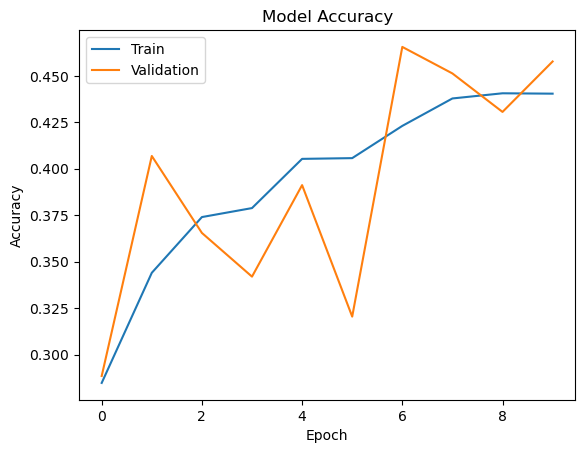


Evaluate model with test data set
4/4 - 0s - 6ms/step - accuracy: 0.4219 - loss: 1.4774

Predict using a model with test data set
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 

Classification Report:
              precision    recall  f1-score   support

           0       0.36      0.84      0.50        32
           1       0.40      0.38      0.39        32
           2       0.38      0.16      0.22        32
           3       1.00      0.31      0.48        32

    accuracy                           0.42       128
   macro avg       0.54      0.42      0.40       128
weighted avg       0.54      0.42      0.40       128


Confusion Matrix:
[[27  2  3  0]
 [15 12  5  0]
 [19  8  5  0]
 [14  8  0 10]]

Heatmap of Confusion Matrix:


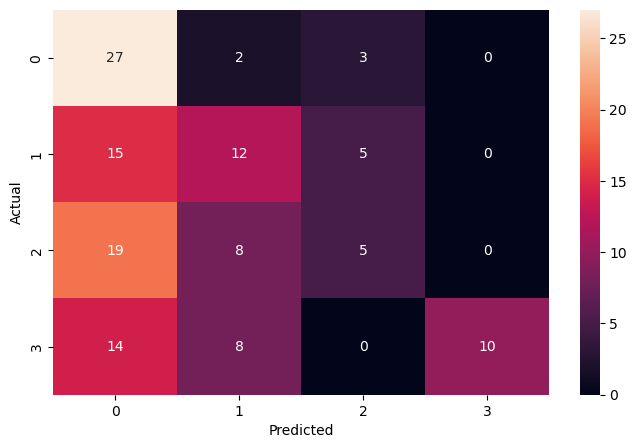

accuracy rate for class happy is 84.4%
accuracy rate for class neutral is 37.5%
accuracy rate for class sad is 15.6%
accuracy rate for class surprise is 31.2%


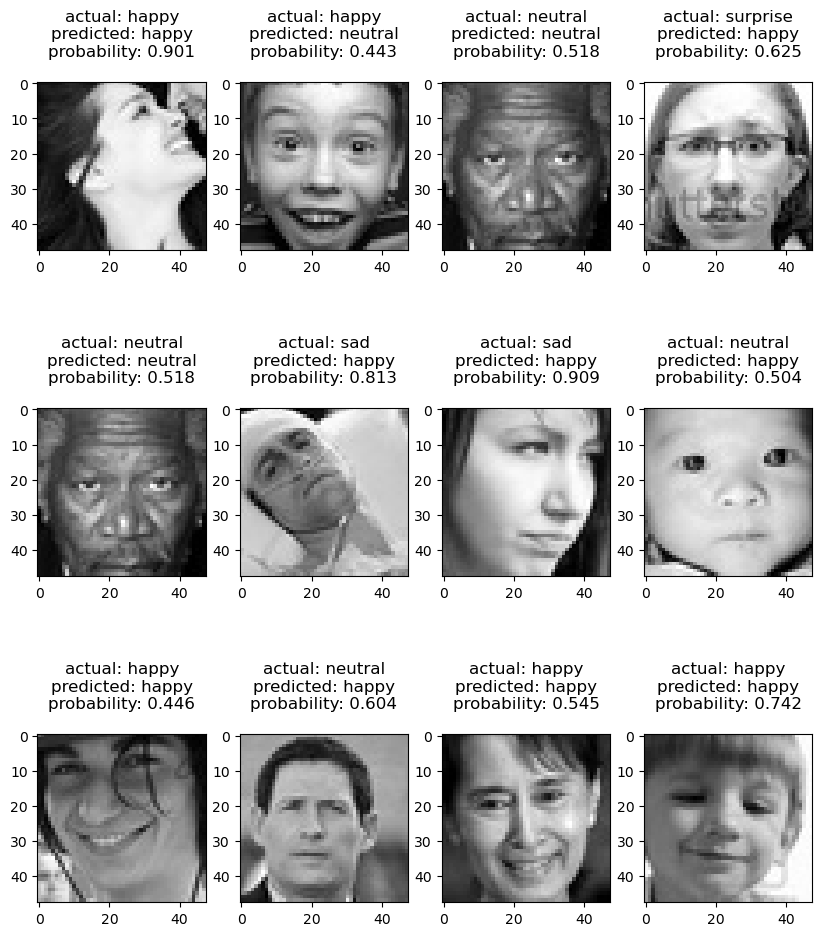

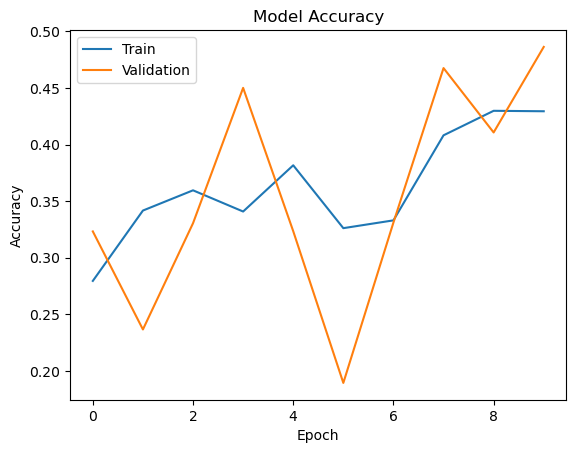


Evaluate model with test data set
4/4 - 0s - 5ms/step - accuracy: 0.4531 - loss: 1.3304

Predict using a model with test data set
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 

Classification Report:
              precision    recall  f1-score   support

           0       0.39      0.81      0.53        32
           1       0.53      0.25      0.34        32
           2       0.30      0.22      0.25        32
           3       0.74      0.53      0.62        32

    accuracy                           0.45       128
   macro avg       0.49      0.45      0.43       128
weighted avg       0.49      0.45      0.43       128


Confusion Matrix:
[[26  0  5  1]
 [14  8  8  2]
 [19  3  7  3]
 [ 8  4  3 17]]

Heatmap of Confusion Matrix:


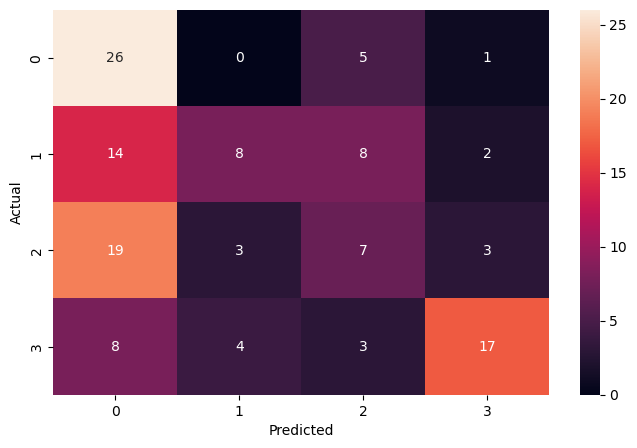

accuracy rate for class happy is 81.2%
accuracy rate for class neutral is 25.0%
accuracy rate for class sad is 21.9%
accuracy rate for class surprise is 53.1%


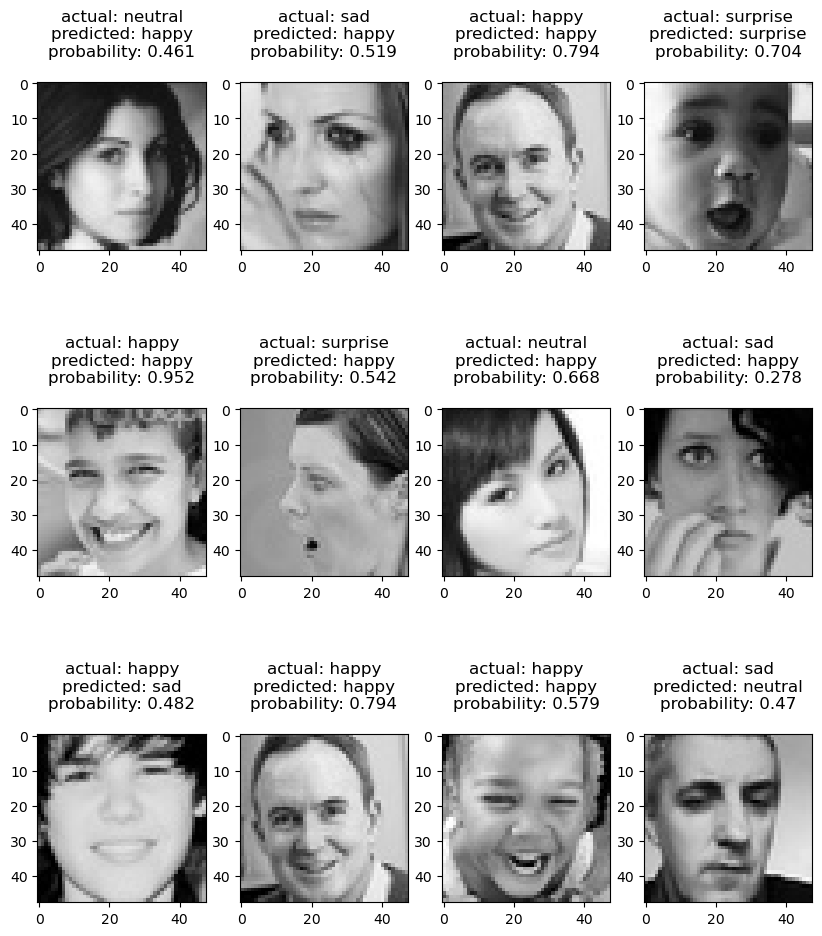

In [11]:
def display_model_accuracy(history):
    # draw a plot of the training and validation accuracy
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.title('Model Accuracy')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Validation'], loc = 'upper left')

    # Display the plot
    plt.show()

def evaluate_model(test_set, model, color_mode="grayscale"):
    # evaluate the model with test set
    test_images, test_labels = next(test_set)

    print("\nEvaluate model with test data set")
    accuracy = model.evaluate(test_images, test_labels, verbose = 2)

    # make predictions on the test set
    print("\nPredict using a model with test data set")
    predicted = model.predict(test_images)

    # convert predictions to class labels
    predicted_classes = np.argmax(predicted, axis=1)
    label_classes = np.argmax(test_labels, axis=1)
    
    # Calculating the probability of the predicted class
    prediction_propbs = np.max(predicted, axis = 1)

    # print classification report
    print("\nClassification Report:")
    print(classification_report(label_classes, predicted_classes))

    # print confusion matrix
    print("\nConfusion Matrix:")
    cm = confusion_matrix(label_classes, predicted_classes)
    print(cm)

    # plotting the heatmap using confusion matrix
    print("\nHeatmap of Confusion Matrix:")

    plt.figure(figsize = (8, 5))
    sns.heatmap(cm, annot = True,  fmt = '.0f')
    plt.ylabel('Actual')
    plt.xlabel('Predicted')

    # Display the plot
    plt.show()

    # calclate rate of correct identification for each digit
    for i in range(4):
        total_i = sum(cm[i])
        accurate_i = cm[i][i]
        percentage = '{:.1f}%'.format(100 * accurate_i / total_i)
        print("accuracy rate for class " + class_names[i] + " is " + str(percentage))

    rows = 3
    cols = 4

    fig = plt.figure(figsize = (10, 12))

    # Clip color image to be in 0..1 to make imshow() work
    if color_mode == "rgb":
        test_images = test_images/255

    for i in range(cols):
        for j in range(rows):
            random_index = np.random.randint(0, len(test_labels))
            ax = fig.add_subplot(rows, cols, i*rows+j+1)
            ax.imshow(test_images[random_index], cmap='gray')
            pred_label = class_names[predicted_classes[random_index]]
            pred_prob = prediction_propbs[random_index]
            true_label = class_names[np.argmax(test_labels[random_index])]
            ax.set_title("actual: {}\npredicted: {}\nprobability: {:.3}\n".format(
                true_label, pred_label, pred_prob
            ))
    plt.show()

display_model_accuracy(history_g)
evaluate_model(test_set_g, ann_model_g)

display_model_accuracy(history_c)
evaluate_model(test_set_c, ann_model_c, "rgb")

**Observations and Insights:__**

* The current ANN model shows slightly better performances with color (rgb) images than grayscale images. The accuracy of the ANN model with grayscale image is 0.4219 and it is 0.4531 with rgb images.   

* With either color mode, the algorithm detect happy emotion better than others. In color mode, suprise is detected almost 53%.

* The accuracy of the model increases with repeat (epoch) for the training set, but the validation acuracy doesn't increase. Too much fluctuation. The performance of this model is so poor to be used. 

### **Creating the Base Convolutional Neural Network**

In [12]:
# Fix the seed for random number generators
np.random.seed(42)

import random

random.seed(42)

tf.random.set_seed(42)

In [13]:
def build_cnn_model_1(color_mode):
    model = Sequential()

    # Define input shape
    if color_mode == "grayscale":
        input_shape = (48, 48, 1)  
    elif color_mode == "rgb":
        input_shape = (48, 48, 3)  

    # First Convolutional Block
    model.add(Conv2D(32, (3, 3), input_shape=input_shape, padding='same'))
    model.add(LeakyReLU(0.1))
    model.add(MaxPooling2D(2, 2))

    # Second Convolutional Block
    model.add(Conv2D(64, (3, 3), padding='same'))
    model.add(LeakyReLU(0.1))
    model.add(MaxPooling2D(2, 2))

    # Third Convolutional Block
    model.add(Conv2D(128, (3, 3), padding='same'))
    model.add(LeakyReLU(0.1))
    model.add(MaxPooling2D(2,2))

    # Fourth Convolutional Block
    model.add(Conv2D(256, (3, 3), padding='same'))
    model.add(LeakyReLU(0.1))
    model.add(MaxPooling2D(2, 2))

    model.add(Flatten())

    # Fully Connected Block
    model.add(Dense(512))
    model.add(LeakyReLU(0.1))

    # Classifier
    model.add(Dense(4, activation = 'softmax'))

    model.compile(loss='categorical_crossentropy',
                        optimizer=Adam(learning_rate=0.001),
                        metrics=['accuracy'])
    
    return model

cnn_model_g = build_cnn_model_1("grayscale")
cnn_model_g.summary()

cnn_model_c = build_cnn_model_1("rgb")
cnn_model_c.summary()

c:\Users\lewis.lee\AppData\Local\anaconda3\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:99: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(


Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 48, 48, 32)     │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu (LeakyReLU)         │ (None, 48, 48, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 24, 24, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 24, 24, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_1 (LeakyReLU)       │ (None, 24, 24, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 12, 12, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 12, 12, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_2 (LeakyReLU)       │ (None, 12, 12, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 6, 6, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 6, 6, 256)      │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_3 (LeakyReLU)       │ (None, 6, 6, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 3, 3, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_2 (Flatten)             │ (None, 2304)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 512)            │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_4 (LeakyReLU)       │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 4)              │         2,052 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,570,052 (5.99 MB)

 Trainable params: 1,570,052 (5.99 MB)

 Non-trainable params: 0 (0.00 B)

Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_4 (Conv2D)               │ (None, 48, 48, 32)     │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_5 (LeakyReLU)       │ (None, 48, 48, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 24, 24, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 24, 24, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_6 (LeakyReLU)       │ (None, 24, 24, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_5 (MaxPooling2D)  │ (None, 12, 12, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_6 (Conv2D)               │ (None, 12, 12, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_7 (LeakyReLU)       │ (None, 12, 12, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_6 (MaxPooling2D)  │ (None, 6, 6, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_7 (Conv2D)               │ (None, 6, 6, 256)      │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_8 (LeakyReLU)       │ (None, 6, 6, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_7 (MaxPooling2D)  │ (None, 3, 3, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_3 (Flatten)             │ (None, 2304)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ (None, 512)            │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_9 (LeakyReLU)       │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_9 (Dense)                 │ (None, 4)              │         2,052 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,570,628 (5.99 MB)

 Trainable params: 1,570,628 (5.99 MB)

 Non-trainable params: 0 (0.00 B)

In [14]:
# Fit on the train data and use validation_set_g for validation
history_g = cnn_model_g.fit(train_set_g, 
                            validation_data=validation_set_g, 
                            epochs=20,
                            verbose=1)

history_c = cnn_model_c.fit(train_set_c, 
                            validation_data=validation_set_c, 
                            epochs=20,
                            verbose=1)

Epoch 1/20
119/119 ━━━━━━━━━━━━━━━━━━━━ 28s 220ms/step - accuracy: 0.3049 - loss: 7.0166 - val_accuracy: 0.4760 - val_loss: 1.1945
Epoch 2/20
119/119 ━━━━━━━━━━━━━━━━━━━━ 27s 220ms/step - accuracy: 0.4733 - loss: 1.1936 - val_accuracy: 0.5849 - val_loss: 0.9763
Epoch 3/20
119/119 ━━━━━━━━━━━━━━━━━━━━ 27s 223ms/step - accuracy: 0.5894 - loss: 0.9709 - val_accuracy: 0.6096 - val_loss: 0.9605
Epoch 4/20
119/119 ━━━━━━━━━━━━━━━━━━━━ 26s 210ms/step - accuracy: 0.6477 - loss: 0.8509 - val_accuracy: 0.6420 - val_loss: 0.8649
Epoch 5/20
119/119 ━━━━━━━━━━━━━━━━━━━━ 26s 213ms/step - accuracy: 0.6783 - loss: 0.7765 - val_accuracy: 0.6717 - val_loss: 0.8212
Epoch 6/20
119/119 ━━━━━━━━━━━━━━━━━━━━ 26s 210ms/step - accuracy: 0.7354 - loss: 0.6531 - val_accuracy: 0.6940 - val_loss: 0.7785
Epoch 7/20
119/119 ━━━━━━━━━━━━━━━━━━━━ 27s 218ms/step - accuracy: 0.7725 - loss: 0.5670 - val_accuracy: 0.6767 - val_loss: 0.8500
Epoch 8/20
119/119 ━━━━━━━━━━━━━━━━━━━━ 26s 212ms/step - accuracy: 0.7961 - loss: 0

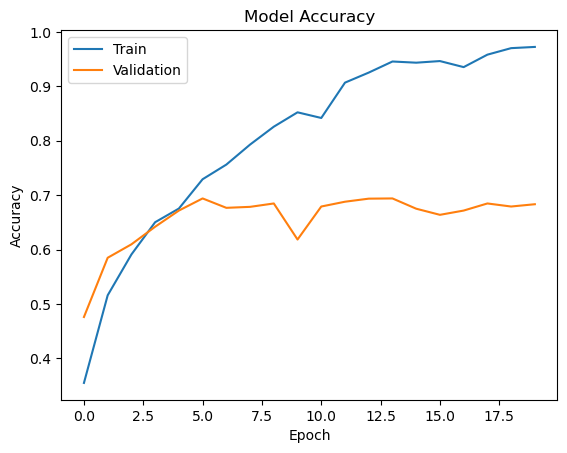


Evaluate model with test data set
4/4 - 0s - 11ms/step - accuracy: 0.6875 - loss: 1.6195

Predict using a model with test data set
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step 

Classification Report:
              precision    recall  f1-score   support

           0       0.70      0.72      0.71        32
           1       0.53      0.78      0.63        32
           2       0.65      0.34      0.45        32
           3       0.94      0.91      0.92        32

    accuracy                           0.69       128
   macro avg       0.70      0.69      0.68       128
weighted avg       0.70      0.69      0.68       128


Confusion Matrix:
[[23  6  2  1]
 [ 2 25  4  1]
 [ 7 14 11  0]
 [ 1  2  0 29]]

Heatmap of Confusion Matrix:


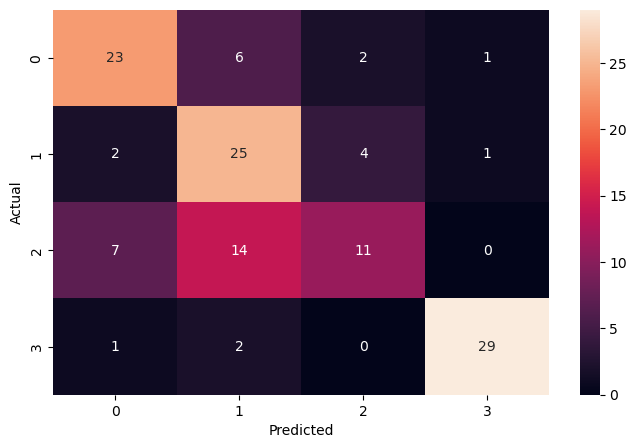

accuracy rate for class happy is 71.9%
accuracy rate for class neutral is 78.1%
accuracy rate for class sad is 34.4%
accuracy rate for class surprise is 90.6%


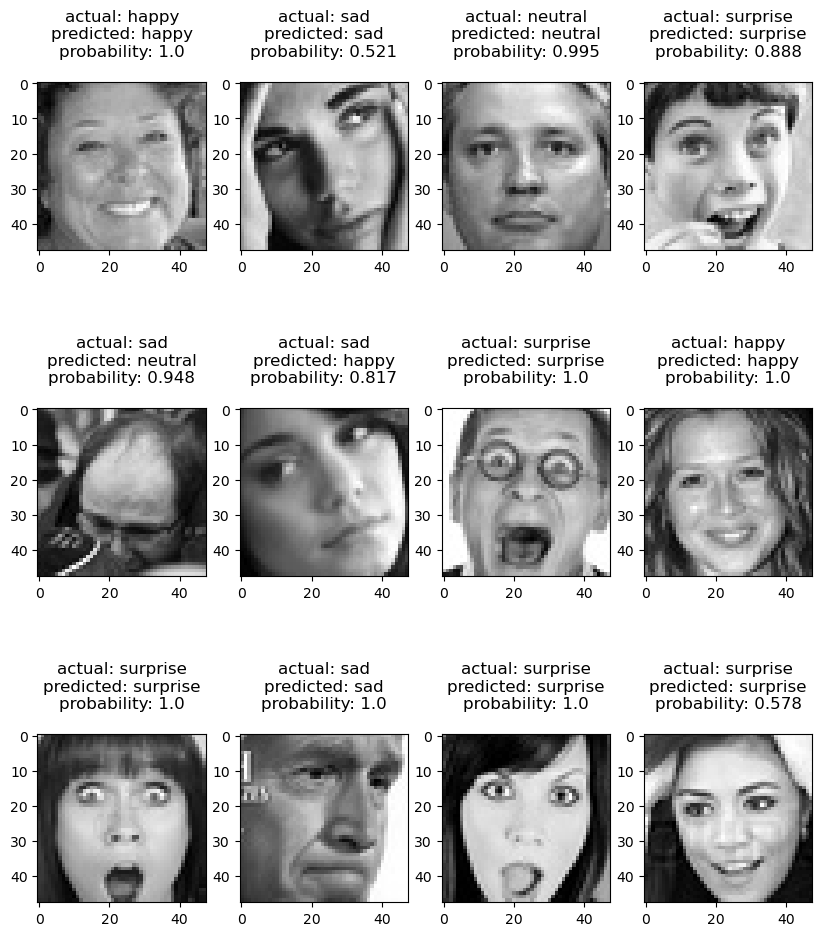

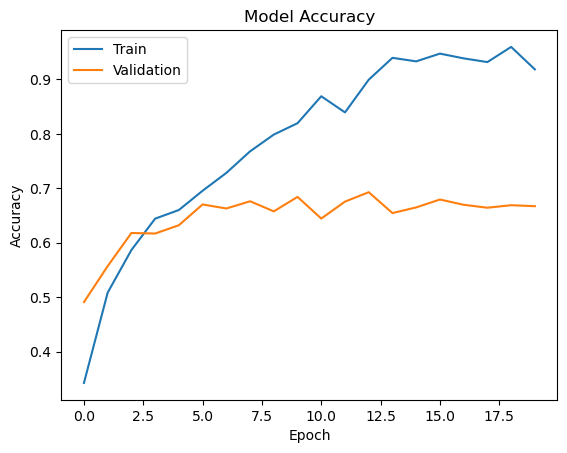


Evaluate model with test data set
4/4 - 0s - 11ms/step - accuracy: 0.7422 - loss: 0.9773

Predict using a model with test data set
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step 

Classification Report:
              precision    recall  f1-score   support

           0       0.82      0.72      0.77        32
           1       0.69      0.69      0.69        32
           2       0.62      0.66      0.64        32
           3       0.85      0.91      0.88        32

    accuracy                           0.74       128
   macro avg       0.74      0.74      0.74       128
weighted avg       0.74      0.74      0.74       128


Confusion Matrix:
[[23  2  4  3]
 [ 2 22  7  1]
 [ 3  7 21  1]
 [ 0  1  2 29]]

Heatmap of Confusion Matrix:


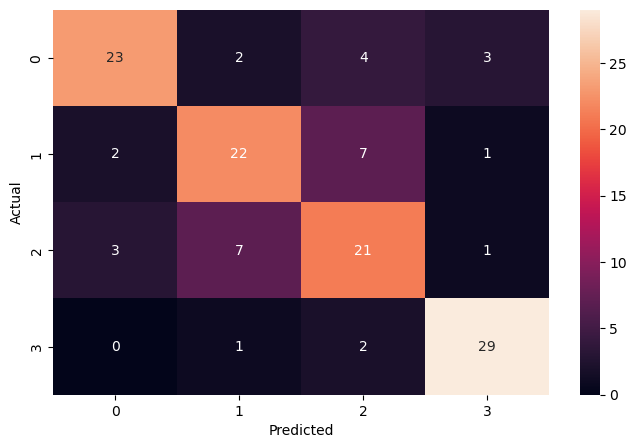

accuracy rate for class happy is 71.9%
accuracy rate for class neutral is 68.8%
accuracy rate for class sad is 65.6%
accuracy rate for class surprise is 90.6%


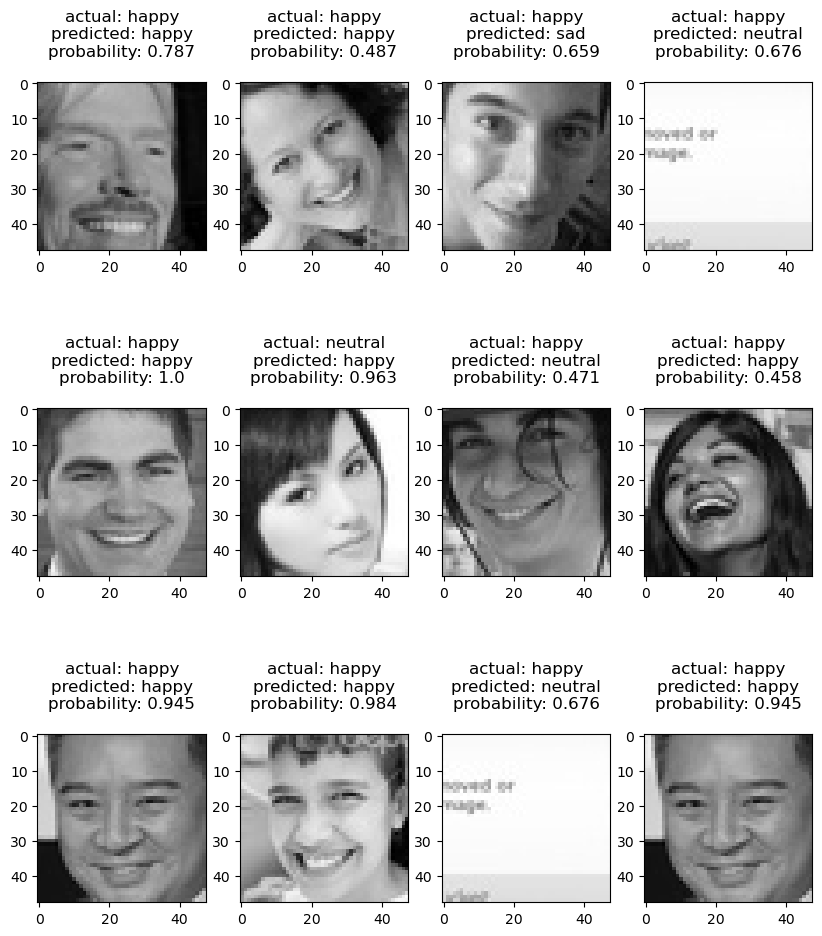

In [15]:
display_model_accuracy(history_g)
evaluate_model(test_set_g, cnn_model_g)

display_model_accuracy(history_c)
evaluate_model(test_set_c, cnn_model_c, "rgb")

**Observations and Insights:__**

* The first CNN model shows better performance than the ANN model. The accuracy is 0.6875 for grayscale images and 0.7422 for color images.   

* The accuracy of the model increases with repeat (epoch) for the training set, but the validation acuracy doesn't increase, which is overfitting. There is no increase after 5 epochs. 

* In color mode, the model detects all emotions for 65~90% accuracy. Particularly, suprise emotion can be detected with 90.6% accuracy. 

* The model still has poor performance to be used but much improved the previous ANN model. 

### **Creating the second Convolutional Neural Network**

- Try out a slightly larger architecture

In [16]:
# Fix the seed for random number generators
np.random.seed(42)

import random

random.seed(42)

tf.random.set_seed(42)

In [17]:
def build_cnn_model_2(color_mode):

    # Create sequential model
    model = Sequential()

    # Define input shape
    if color_mode == "grayscale":
        input_shape = (48, 48, 1)  
    elif color_mode == "rgb":
        input_shape = (48, 48, 3)  

    # first convolutional layer with 16 filters, kernel size of 3x3, 'same' padding, and input shape
    model.add(Conv2D(filters=16, kernel_size=(3, 3), padding='same', input_shape=input_shape))

    # add a LeakyRelu layer with the slope equal to 0.1
    model.add(LeakyReLU(alpha=0.1))

    # second convolutional layer with 32 filters, kernel size of 3x3, and 'same' padding
    model.add(Conv2D(32, (3, 3), padding='same'))

    # add another LeakyRelu with the slope equal to 0.1
    model.add(LeakyReLU(alpha=0.1))

    # add max pooling layer with pool size of 2x2
    model.add(MaxPooling2D(pool_size=(2, 2)))

    # add batch normalization layer
    model.add(BatchNormalization())

    # third convolutional layer with 32 filters, kernel size of 3x3, and 'same' padding
    model.add(Conv2D(32, (3, 3), padding='same'))
    model.add(LeakyReLU(alpha=0.1))

    # fourth convolutional layer with 64 filters, kernel size of 3x3, and 'same' padding
    model.add(Conv2D(64, (3, 3), padding='same'))
    model.add(LeakyReLU(alpha=0.1))

    # add max pooling layer with pool size of 2x2
    model.add(MaxPooling2D(pool_size=(2, 2)))

    # add batch normalization layer
    model.add(BatchNormalization())

    # flatten the output from the previous layer
    model.add(Flatten())

    # add a dense layer with 32 nodes
    model.add(Dense(32))
    model.add(LeakyReLU(alpha=0.1))

    # add a dropout layer with rate 0.5
    model.add(Dropout(0.5))

    # final output layer with nodes equal to the number of classes, i.e., 4 and 'softmax' as the activation function
    model.add(Dense(4, activation='softmax'))

    # compile the model with the loss equal to categorical_crossentropy,
    # optimizer equal to Adam(learning_rate = 0.001), and metric equal to 'accuracy'.
    model.compile(loss='categorical_crossentropy',
                  optimizer=Adam(learning_rate=0.001),
                  metrics=['accuracy'])

    return model


cnn_model_g = build_cnn_model_2("grayscale")
cnn_model_g.summary()

cnn_model_c = build_cnn_model_2("rgb")
cnn_model_c.summary()

c:\Users\lewis.lee\AppData\Local\anaconda3\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:99: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(
c:\Users\lewis.lee\AppData\Local\anaconda3\Lib\site-packages\keras\src\layers\activations\leaky_relu.py:41: UserWarning: Argument `alpha` is deprecated. Use `negative_slope` instead.
  warnings.warn(


Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_8 (Conv2D)               │ (None, 48, 48, 16)     │           160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_10 (LeakyReLU)      │ (None, 48, 48, 16)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_9 (Conv2D)               │ (None, 48, 48, 32)     │         4,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_11 (LeakyReLU)      │ (None, 48, 48, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_8 (MaxPooling2D)  │ (None, 24, 24, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 24, 24, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_10 (Conv2D)              │ (None, 24, 24, 32)     │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_12 (LeakyReLU)      │ (None, 24, 24, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_11 (Conv2D)              │ (None, 24, 24, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_13 (LeakyReLU)      │ (None, 24, 24, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_9 (MaxPooling2D)  │ (None, 12, 12, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 12, 12, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_4 (Flatten)             │ (None, 9216)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_10 (Dense)                │ (None, 32)             │       294,944 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_14 (LeakyReLU)      │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_11 (Dense)                │ (None, 4)              │           132 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 328,004 (1.25 MB)

 Trainable params: 327,812 (1.25 MB)

 Non-trainable params: 192 (768.00 B)

Model: "sequential_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_12 (Conv2D)              │ (None, 48, 48, 16)     │           448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_15 (LeakyReLU)      │ (None, 48, 48, 16)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_13 (Conv2D)              │ (None, 48, 48, 32)     │         4,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_16 (LeakyReLU)      │ (None, 48, 48, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_10 (MaxPooling2D) │ (None, 24, 24, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 24, 24, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_14 (Conv2D)              │ (None, 24, 24, 32)     │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_17 (LeakyReLU)      │ (None, 24, 24, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_15 (Conv2D)              │ (None, 24, 24, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_18 (LeakyReLU)      │ (None, 24, 24, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_11 (MaxPooling2D) │ (None, 12, 12, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 12, 12, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_5 (Flatten)             │ (None, 9216)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_12 (Dense)                │ (None, 32)             │       294,944 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_19 (LeakyReLU)      │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_13 (Dense)                │ (None, 4)              │           132 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 328,292 (1.25 MB)

 Trainable params: 328,100 (1.25 MB)

 Non-trainable params: 192 (768.00 B)

### **Compiling and Training the Model**

In [18]:
# Fit on the train data and use validation_set_g for validation
history_g = cnn_model_g.fit(train_set_g, 
                            validation_data=validation_set_g, 
                            epochs=30,
                            verbose=1)

# Fit on the train data and use validation_set_c for validation
history_c = cnn_model_c.fit(train_set_c, 
                            validation_data=validation_set_c, 
                            epochs=30,
                            verbose=1)

Epoch 1/30
119/119 ━━━━━━━━━━━━━━━━━━━━ 32s 250ms/step - accuracy: 0.3665 - loss: 1.5780 - val_accuracy: 0.4676 - val_loss: 1.1987
Epoch 2/30
119/119 ━━━━━━━━━━━━━━━━━━━━ 37s 302ms/step - accuracy: 0.5084 - loss: 1.1631 - val_accuracy: 0.5110 - val_loss: 1.1804
Epoch 3/30
119/119 ━━━━━━━━━━━━━━━━━━━━ 38s 305ms/step - accuracy: 0.5639 - loss: 1.0418 - val_accuracy: 0.5602 - val_loss: 1.0455
Epoch 4/30
119/119 ━━━━━━━━━━━━━━━━━━━━ 36s 297ms/step - accuracy: 0.6190 - loss: 0.9103 - val_accuracy: 0.6152 - val_loss: 0.9368
Epoch 5/30
119/119 ━━━━━━━━━━━━━━━━━━━━ 32s 257ms/step - accuracy: 0.6719 - loss: 0.8010 - val_accuracy: 0.6122 - val_loss: 1.0193
Epoch 6/30
119/119 ━━━━━━━━━━━━━━━━━━━━ 29s 235ms/step - accuracy: 0.7042 - loss: 0.6972 - val_accuracy: 0.6711 - val_loss: 0.8397
Epoch 7/30
119/119 ━━━━━━━━━━━━━━━━━━━━ 28s 228ms/step - accuracy: 0.7410 - loss: 0.6204 - val_accuracy: 0.6512 - val_loss: 0.9219
Epoch 8/30
119/119 ━━━━━━━━━━━━━━━━━━━━ 29s 234ms/step - accuracy: 0.7602 - loss: 0

### **Evaluating the Model on the Test Set**

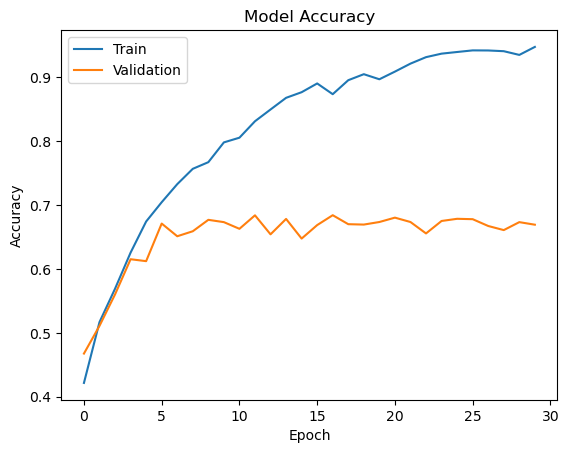


Evaluate model with test data set
4/4 - 0s - 73ms/step - accuracy: 0.6797 - loss: 1.1261

Predict using a model with test data set
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 35ms/step

Classification Report:
              precision    recall  f1-score   support

           0       0.72      0.66      0.69        32
           1       0.58      0.69      0.63        32
           2       0.59      0.50      0.54        32
           3       0.82      0.88      0.85        32

    accuracy                           0.68       128
   macro avg       0.68      0.68      0.68       128
weighted avg       0.68      0.68      0.68       128


Confusion Matrix:
[[21  5  4  2]
 [ 4 22  5  1]
 [ 2 11 16  3]
 [ 2  0  2 28]]

Heatmap of Confusion Matrix:


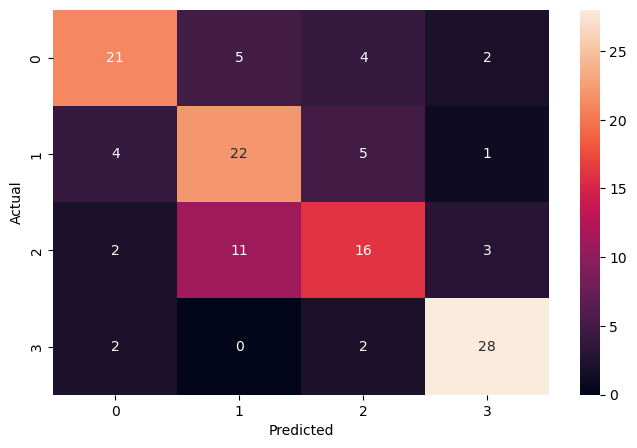

accuracy rate for class happy is 65.6%
accuracy rate for class neutral is 68.8%
accuracy rate for class sad is 50.0%
accuracy rate for class surprise is 87.5%


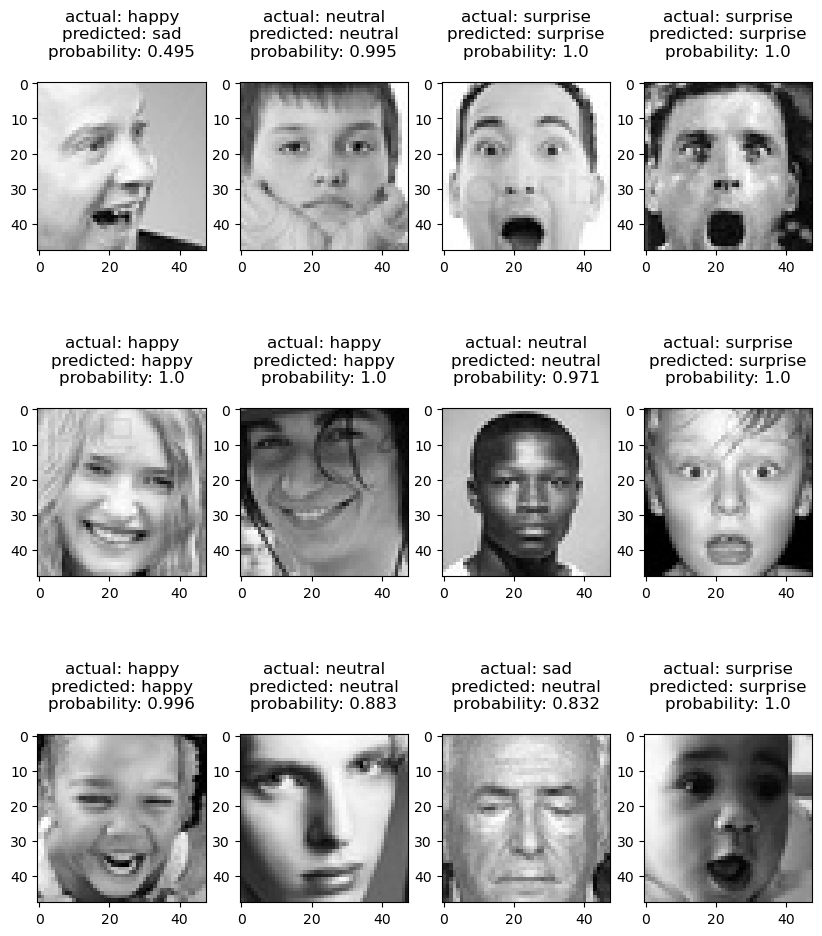

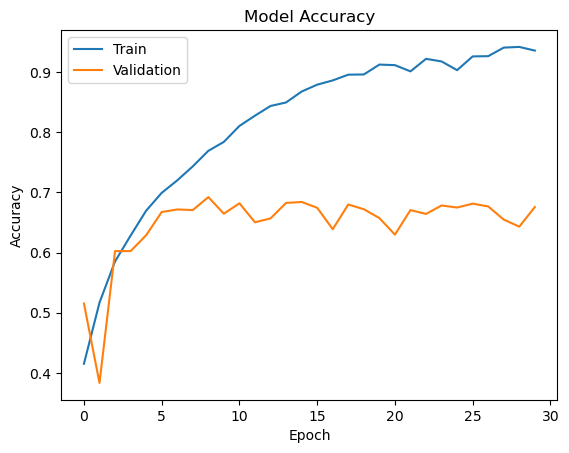


Evaluate model with test data set
4/4 - 0s - 23ms/step - accuracy: 0.6797 - loss: 1.3618

Predict using a model with test data set
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step 

Classification Report:
              precision    recall  f1-score   support

           0       0.68      0.78      0.72        32
           1       0.64      0.66      0.65        32
           2       0.52      0.44      0.47        32
           3       0.87      0.84      0.86        32

    accuracy                           0.68       128
   macro avg       0.68      0.68      0.68       128
weighted avg       0.68      0.68      0.68       128


Confusion Matrix:
[[25  4  2  1]
 [ 2 21  8  1]
 [ 8  8 14  2]
 [ 2  0  3 27]]

Heatmap of Confusion Matrix:


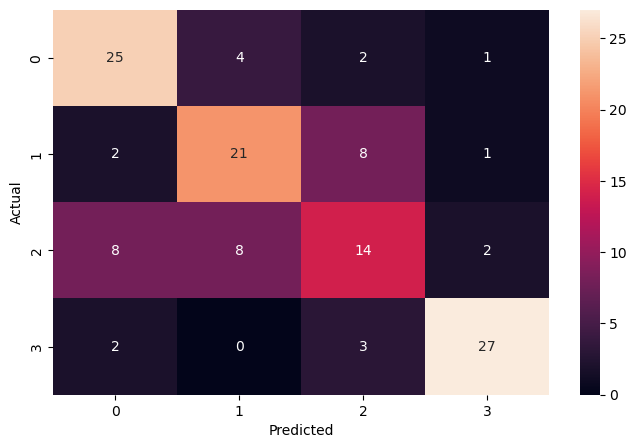

accuracy rate for class happy is 78.1%
accuracy rate for class neutral is 65.6%
accuracy rate for class sad is 43.8%
accuracy rate for class surprise is 84.4%


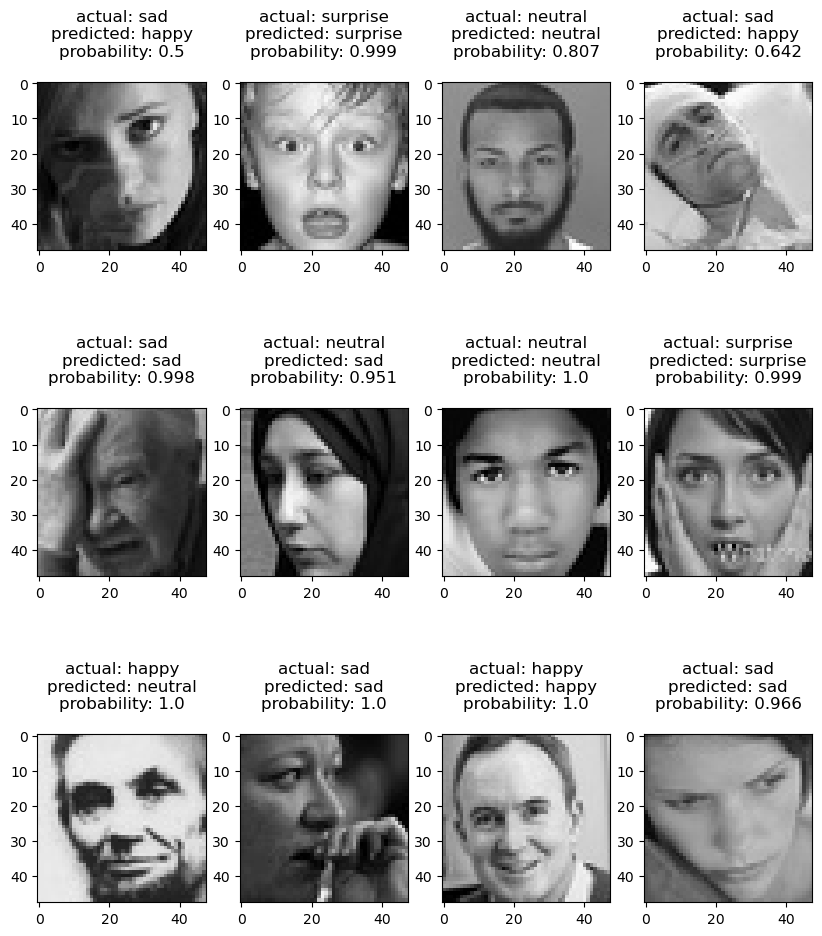

In [19]:
display_model_accuracy(history_g)
evaluate_model(test_set_g, cnn_model_g)

display_model_accuracy(history_c)
evaluate_model(test_set_c, cnn_model_c, "rgb")

**Observations and Insights:__**

* Batch Normalization layer is added to the CNN model. The layer is added to improve training stability and speed up convergence. However, the accuracy is reduced to 0.6797 for grayscale and 0.6797 for color (from 0.6875 for grayscale and 0.7422 for color in the first CNN model).

* In either color mode, the overfitting issue still exists. 


## **Think About It:**

* Did the models have a satisfactory performance? If not, then what are the possible reasons?

Any of the models did not show a satisfactory performance. It may be because there is not enough training data, or model needs to be more tuned. 

* Which Color mode showed better overall performance? What are the possible reasons? Do you think having 'rgb' color mode is needed because the images are already black and white?

Overall, the color mode shows the better performance even though the images are in grayscale mode. When an image is converted into rgb, the image contains additioanl color channels. This additional color channels may increase the performance.   

## **Transfer Learning Architectures**

In this section, we will create several Transfer Learning architectures. For the pre-trained models, we will select three popular architectures namely, VGG16, ResNet v2, and Efficient Net. The difference between these architectures and the previous architectures is that these will require 3 input channels while the earlier ones worked on 'grayscale' images. Therefore, we need to create new DataLoaders.

### **Creating our Data Loaders for Transfer Learning Architectures**

In this section, we are creating data loaders that we will use as inputs to our Neural Network. We will have to go with color_mode = 'rgb' as this is the required format for the transfer learning architectures.

In [20]:
# This operation was already done before, and data loaded with color_mode='rgb'.
# It is done again here to match with the instruction.
train_set_c, validation_set_c, test_set_c = loading_data("rgb", 48)

Load images of train dataset: Found 15109 images belonging to 4 classes.
Load images of validation dataset: Found 4977 images belonging to 4 classes.
Load images of test dataset: Found 128 images belonging to 4 classes.


## **VGG16 Model**

### **Importing the VGG16 Architecture**

In [21]:
# Clearing backend
backend.clear_session()

# Fix the seed for random number generators
np.random.seed(42)

import random

random.seed(42)

tf.random.set_seed(42)

### **Model Building**

- Import VGG16 upto the layer of your choice and add Fully Connected layers on top of it.

In [22]:
vgg_model_base = VGG16(weights='imagenet',
                       include_top=False,
                       input_shape=(48, 48, 3), 
                       pooling = 'max')

# Checking summary of the model
vgg_model_base.summary()

Model: "vgg16"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 48, 48, 3)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv1 (Conv2D)           │ (None, 48, 48, 64)     │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv2 (Conv2D)           │ (None, 48, 48, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_pool (MaxPooling2D)      │ (None, 24, 24, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv1 (Conv2D)           │ (None, 24, 24, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv2 (Conv2D)           │ (None, 24, 24, 128)    │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_pool (MaxPooling2D)      │ (None, 12, 12, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv1 (Conv2D)           │ (None, 12, 12, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv2 (Conv2D)           │ (None, 12, 12, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv3 (Conv2D)           │ (None, 12, 12, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_pool (MaxPooling2D)      │ (None, 6, 6, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv1 (Conv2D)           │ (None, 6, 6, 512)      │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv2 (Conv2D)           │ (None, 6, 6, 512)      │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv3 (Conv2D)           │ (None, 6, 6, 512)      │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_pool (MaxPooling2D)      │ (None, 3, 3, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv1 (Conv2D)           │ (None, 3, 3, 512)      │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv2 (Conv2D)           │ (None, 3, 3, 512)      │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv3 (Conv2D)           │ (None, 3, 3, 512)      │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_pool (MaxPooling2D)      │ (None, 1, 1, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_max_pooling2d            │ (None, 512)            │             0 │
│ (GlobalMaxPooling2D)            │                        │               │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 14,714,688 (56.13 MB)

 Trainable params: 14,714,688 (56.13 MB)

 Non-trainable params: 0 (0.00 B)

### **Compiling and Training the VGG16 Model**

In [23]:
transfer_layer = vgg_model_base.get_layer('block3_pool')

vgg_model_base.trainable = False

# Add classification layers on top of it
x = Flatten()(transfer_layer.output)

x = Dense(256, activation = 'relu')(x)

x = Dense(128, activation = 'relu')(x)

x = Dropout(0.3)(x)

x = Dense(64, activation = 'relu')(x)

x = BatchNormalization()(x)

pred = Dense(4, activation = 'softmax')(x)

# Initializing the model
vgg_model = Model(vgg_model_base.input, pred)

# Compiling the model
vgg_model.compile(loss = 'categorical_crossentropy',
                  optimizer = tf.keras.optimizers.Adamax(learning_rate = 0.0005),
                  metrics = ['accuracy'])

# Fitting the model
history_c = vgg_model.fit(train_set_c, 
                          validation_data=validation_set_c, 
                          epochs=10,
                          batch_size=250,
                          validation_split=0.1,
                          verbose=2)

Epoch 1/10


c:\Users\lewis.lee\AppData\Local\anaconda3\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:120: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


119/119 - 69s - 584ms/step - accuracy: 0.5244 - loss: 1.1593 - val_accuracy: 0.6174 - val_loss: 0.8919
Epoch 2/10
119/119 - 65s - 543ms/step - accuracy: 0.6309 - loss: 0.9099 - val_accuracy: 0.6815 - val_loss: 0.7771
Epoch 3/10
119/119 - 61s - 510ms/step - accuracy: 0.6709 - loss: 0.8047 - val_accuracy: 0.6789 - val_loss: 0.7760
Epoch 4/10
119/119 - 55s - 465ms/step - accuracy: 0.6980 - loss: 0.7592 - val_accuracy: 0.6976 - val_loss: 0.7260
Epoch 5/10
119/119 - 58s - 488ms/step - accuracy: 0.7168 - loss: 0.7073 - val_accuracy: 0.7000 - val_loss: 0.7226
Epoch 6/10
119/119 - 60s - 505ms/step - accuracy: 0.7331 - loss: 0.6706 - val_accuracy: 0.6966 - val_loss: 0.7402
Epoch 7/10
119/119 - 50s - 423ms/step - accuracy: 0.7506 - loss: 0.6277 - val_accuracy: 0.7012 - val_loss: 0.7442
Epoch 8/10
119/119 - 51s - 429ms/step - accuracy: 0.7654 - loss: 0.5906 - val_accuracy: 0.6952 - val_loss: 0.7425
Epoch 9/10
119/119 - 60s - 500ms/step - accuracy: 0.7767 - loss: 0.5694 - val_accuracy: 0.7117 - va

### **Evaluating the VGG16 model**

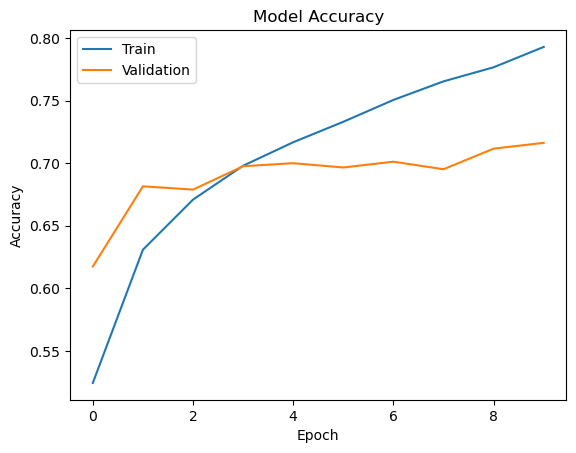


Evaluate model with test data set
4/4 - 0s - 108ms/step - accuracy: 0.8203 - loss: 0.5168

Predict using a model with test data set
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step

Classification Report:
              precision    recall  f1-score   support

           0       0.93      0.84      0.89        32
           1       0.70      0.81      0.75        32
           2       0.72      0.72      0.72        32
           3       0.97      0.91      0.94        32

    accuracy                           0.82       128
   macro avg       0.83      0.82      0.82       128
weighted avg       0.83      0.82      0.82       128


Confusion Matrix:
[[27  1  3  1]
 [ 1 26  5  0]
 [ 1  8 23  0]
 [ 0  2  1 29]]

Heatmap of Confusion Matrix:


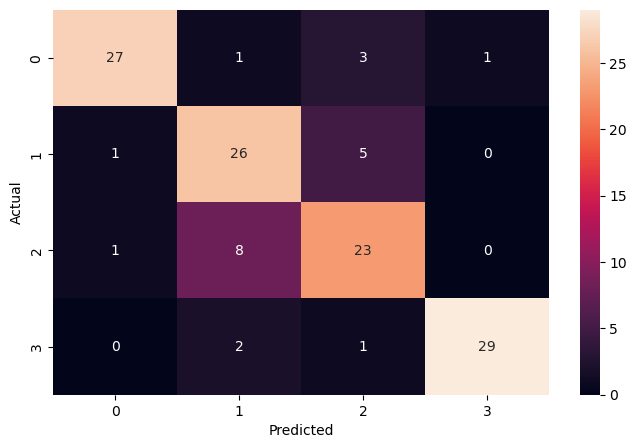

accuracy rate for class happy is 84.4%
accuracy rate for class neutral is 81.2%
accuracy rate for class sad is 71.9%
accuracy rate for class surprise is 90.6%


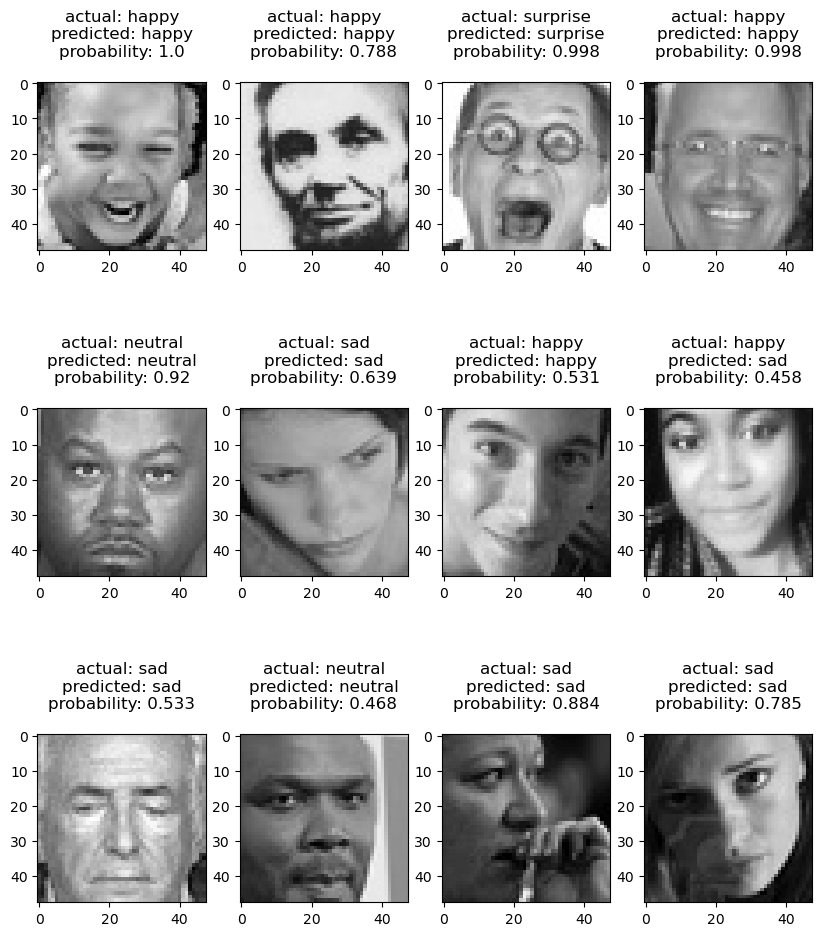

In [24]:
display_model_accuracy(history_c)
evaluate_model(test_set_c, vgg_model, "rgb")

**Think About It:**

- What do you infer from the general trend in the training performance? 
- Is the training accuracy consistently improving? 
- Is the validation accuracy also improving similarly?

**Observations and Insights:__**

* This VGG16 model shows better accuracy than the previous model. The accuracy is 0.8203 for color mode. However, the model still has overfitting issue. 

* The model can detect all emotions fairly well (80~90%), but sad emition detect rate is still 71.9%. 

**Note: You can even go back and build your own architecture on top of the VGG16 Transfer layer and see if you can improve the performance**

## **ResNet V2 Model**

In [25]:
# Clearing backend
backend.clear_session()

# Fix the seed for random number generators
np.random.seed(42)

import random

random.seed(42)

tf.random.set_seed(42)

### **Model Building**

- Import Resnet v2 upto the layer of your choice and add Fully Connected layers on top of it.

In [26]:
# Load ResNet50V2 model without including the top layers
res_model_base = ResNet50V2(weights='imagenet', 
                            include_top=False, 
                            input_shape=(224, 224, 3))

# Freeze each of the layers in the base model
for layer in res_model_base.layers:
    layer.trainable = False

# Add fully connected layers on top of the base model
x = Flatten()(res_model_base.output)
x = Dense(128, activation='relu')(x)
x = Dense(64, activation='relu')(x)
output = Dense(4, activation='softmax')(x)

# Create the final model
rsn_model = Model(inputs=res_model_base.input, outputs=output)

# Compile the model
rsn_model.compile(loss='categorical_crossentropy', 
                    optimizer='adam', 
                    metrics=['accuracy'])

# Print model summary
rsn_model.summary()

94668760/94668760 ━━━━━━━━━━━━━━━━━━━━ 20s 0us/step


Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_pad           │ (None, 230, 230,  │          0 │ input_layer[0][0] │
│ (ZeroPadding2D)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_conv (Conv2D) │ (None, 112, 112,  │      9,472 │ conv1_pad[0][0]   │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pad           │ (None, 114, 114,  │          0 │ conv1_conv[0][0]  │
│ (ZeroPadding2D)     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pool          │ (None, 56, 56,    │          0 │ pool1_pad[0][0]   │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_preac… │ (None, 56, 56,    │        256 │ pool1_pool[0][0]  │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_preac… │ (None, 56, 56,    │          0 │ conv2_block1_pre… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_conv │ (None, 56, 56,    │      4,096 │ conv2_block1_pre… │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_bn   │ (None, 56, 56,    │        256 │ conv2_block1_1_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_relu │ (None, 56, 56,    │          0 │ conv2_block1_1_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_pad  │ (None, 58, 58,    │          0 │ conv2_block1_1_r… │
│ (ZeroPadding2D)     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_conv │ (None, 56, 56,    │     36,864 │ conv2_block1_2_p… │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_bn   │ (None, 56, 56,    │        256 │ conv2_block1_2_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_relu │ (None, 56, 56,    │          0 │ conv2_block1_2_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_conv │ (None, 56, 56,    │     16,640 │ conv2_block1_pre… │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_3_conv │ (None, 56, 56,    │     16,640 │ conv2_block1_2_r… │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_out    │ (None, 56, 56,    │          0 │ conv2_block1_0_c

 Total params: 36,418,500 (138.93 MB)

 Trainable params: 12,853,700 (49.03 MB)

 Non-trainable params: 23,564,800 (89.89 MB)

### **Compiling and Training the Model**

In [27]:
# reload dataset for ResNetV2 model with the size of (224, 224) since 
# ResNetV2 requires image of (224, 224) resolution
train_set_224_g, validation_set_224_g, test_set_224_g = loading_data("grayscale", 224)
train_set_224_c, validation_set_224_c, test_set_224_c = loading_data("rgb", 224)

# Fitting the model
history_c = rsn_model.fit(train_set_224_c, 
                          validation_data=validation_set_224_c, 
                          epochs=10,
                          batch_size=250,
                          validation_split=0.1,
                          verbose=2)

Load images of train dataset: Found 15109 images belonging to 4 classes.
Load images of validation dataset: Found 4977 images belonging to 4 classes.
Load images of test dataset: Found 128 images belonging to 4 classes.
Load images of train dataset: Found 15109 images belonging to 4 classes.
Load images of validation dataset: Found 4977 images belonging to 4 classes.
Load images of test dataset: Found 128 images belonging to 4 classes.
Epoch 1/10


c:\Users\lewis.lee\AppData\Local\anaconda3\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:120: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


119/119 - 409s - 3s/step - accuracy: 0.3457 - loss: 261.6402 - val_accuracy: 0.4766 - val_loss: 178.2493
Epoch 2/10
119/119 - 408s - 3s/step - accuracy: 0.4360 - loss: 78.7393 - val_accuracy: 0.4346 - val_loss: 63.6475
Epoch 3/10
119/119 - 468s - 4s/step - accuracy: 0.4719 - loss: 73.4228 - val_accuracy: 0.5373 - val_loss: 36.3206
Epoch 4/10
119/119 - 459s - 4s/step - accuracy: 0.5258 - loss: 44.6958 - val_accuracy: 0.5598 - val_loss: 33.3042
Epoch 5/10
119/119 - 364s - 3s/step - accuracy: 0.5323 - loss: 45.2998 - val_accuracy: 0.4629 - val_loss: 73.6131
Epoch 6/10
119/119 - 356s - 3s/step - accuracy: 0.5535 - loss: 37.8947 - val_accuracy: 0.4553 - val_loss: 31.3531
Epoch 7/10
119/119 - 354s - 3s/step - accuracy: 0.6123 - loss: 17.5196 - val_accuracy: 0.4971 - val_loss: 35.6491
Epoch 8/10
119/119 - 351s - 3s/step - accuracy: 0.5987 - loss: 19.7331 - val_accuracy: 0.5316 - val_loss: 21.5989
Epoch 9/10
119/119 - 351s - 3s/step - accuracy: 0.6545 - loss: 11.7777 - val_accuracy: 0.4049 - v

### **Evaluating the ResNet Model**

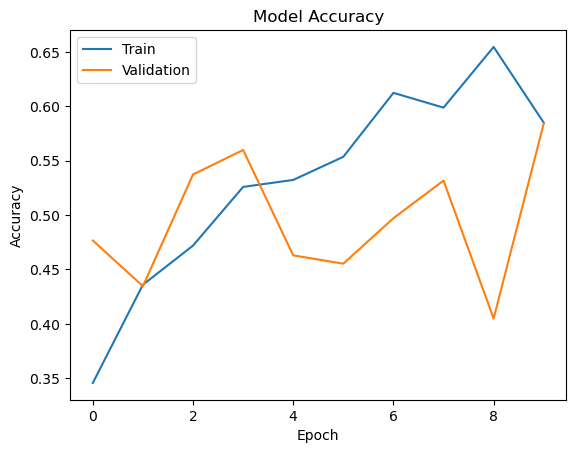


Evaluate model with test data set
4/4 - 2s - 618ms/step - accuracy: 0.5703 - loss: 10.6413

Predict using a model with test data set
4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 609ms/step

Classification Report:
              precision    recall  f1-score   support

           0       0.67      0.62      0.65        32
           1       0.46      0.56      0.51        32
           2       0.56      0.44      0.49        32
           3       0.62      0.66      0.64        32

    accuracy                           0.57       128
   macro avg       0.58      0.57      0.57       128
weighted avg       0.58      0.57      0.57       128


Confusion Matrix:
[[20  5  3  4]
 [ 2 18  6  6]
 [ 5 10 14  3]
 [ 3  6  2 21]]

Heatmap of Confusion Matrix:


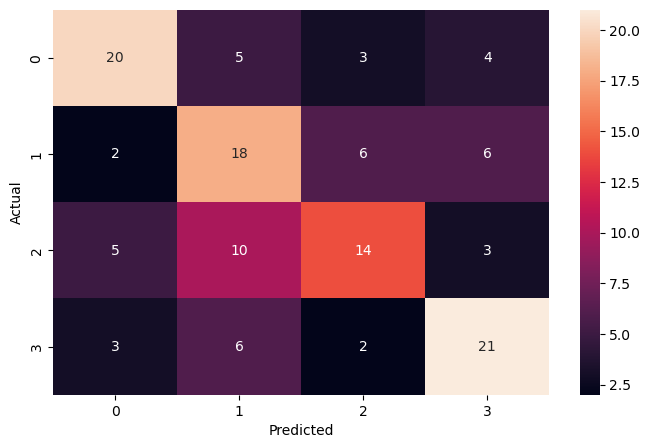

accuracy rate for class happy is 62.5%
accuracy rate for class neutral is 56.2%
accuracy rate for class sad is 43.8%
accuracy rate for class surprise is 65.6%


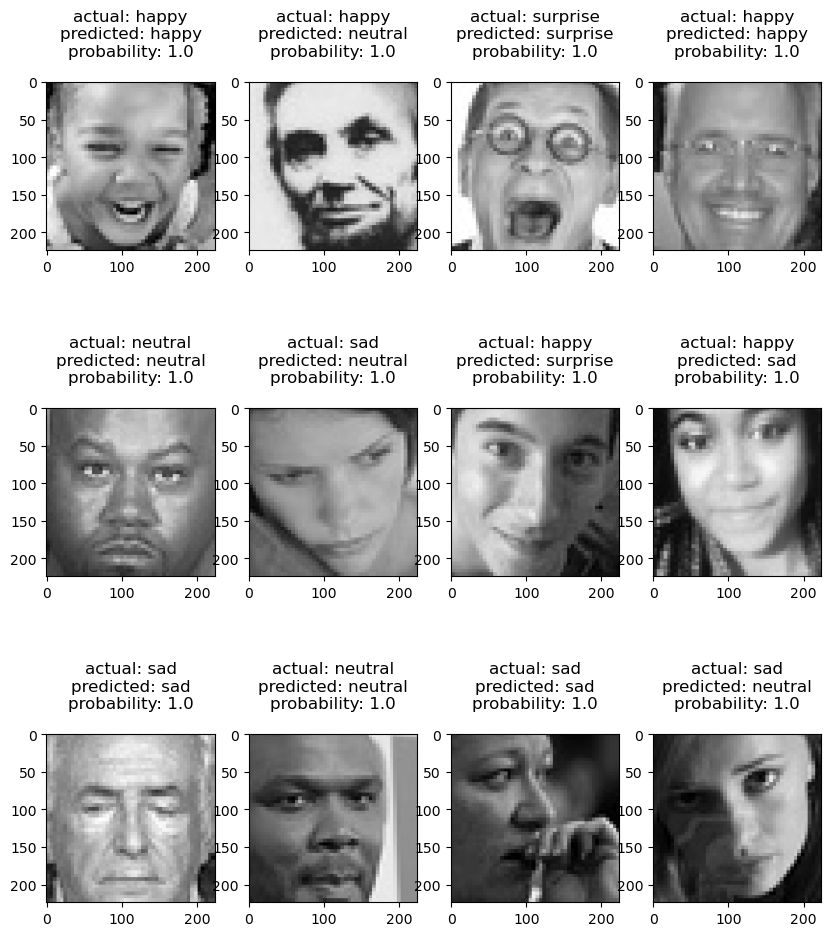

In [28]:
display_model_accuracy(history_c)
evaluate_model(test_set_224_c, rsn_model, "rgb")

**Observations and Insights:__**

* ResNet model showed the worst performace so far. Its accuracy is 0.5703. The accurary is decreased after 8th training (epoch = 8). Its validation accuracy fluctuates also. 

* Detection rate for each emotions are also in 43~65% which is not usable in practice. 

## **EfficientNet Model**

In [29]:
# Clearing backend
backend.clear_session()

# Fix the seed for random number generators
np.random.seed(42)

import random

random.seed(42)

tf.random.set_seed(42)

### **Model Building**

- Import EfficientNet upto the layer of your choice and add Fully Connected layers on top of it.

In [30]:
# Load EfficientNetB0 pre-trained on ImageNet
eff_model_base = EfficientNetB0(weights='imagenet', 
                                include_top=False, 
                                input_shape=(224, 224, 3))

# Freeze the base model layers
for layer in eff_model_base.layers:
    layer.trainable = False

# Add additional layers for fine-tuning
x = GlobalAveragePooling2D()(eff_model_base.output)
x = Dense(128, activation='relu')(x)
output = Dense(4, activation='softmax')(x)

# Create the final model
eff_model = Model(inputs=eff_model_base.input, outputs=output)

# Compile the model
eff_model.compile(loss='categorical_crossentropy', 
                  optimizer=Adam(learning_rate=0.001), 
                  metrics=['accuracy'])


# Print model summary
eff_model.summary()

16705208/16705208 ━━━━━━━━━━━━━━━━━━━━ 3s 0us/step


Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ rescaling           │ (None, 224, 224,  │          0 │ input_layer[0][0] │
│ (Rescaling)         │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ normalization       │ (None, 224, 224,  │          7 │ rescaling[0][0]   │
│ (Normalization)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ rescaling_1         │ (None, 224, 224,  │          0 │ normalization[0]… │
│ (Rescaling)         │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_conv_pad       │ (None, 225, 225,  │          0 │ rescaling_1[0][0] │
│ (ZeroPadding2D)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_conv (Conv2D)  │ (None, 112, 112,  │        864 │ stem_conv_pad[0]… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_bn             │ (None, 112, 112,  │        128 │ stem_conv[0][0]   │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_activation     │ (None, 112, 112,  │          0 │ stem_bn[0][0]     │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_dwconv      │ (None, 112, 112,  │        288 │ stem_activation[… │
│ (DepthwiseConv2D)   │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_bn          │ (None, 112, 112,  │        128 │ block1a_dwconv[0… │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_activation  │ (None, 112, 112,  │          0 │ block1a_bn[0][0]  │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_squeeze  │ (None, 32)        │          0 │ block1a_activati… │
│ (GlobalAveragePool… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_reshape  │ (None, 1, 1, 32)  │          0 │ block1a_se_squee… │
│ (Reshape)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_reduce   │ (None, 1, 1, 8)   │        264 │ block1a_se_resha… │
│ (Conv2D)            │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_expand   │ (None, 1, 1, 32)  │        288 │ block1a_se_reduc… │
│ (Conv2D)            │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_excite   │ (None, 112, 112,  │          0 │ block1a_activati… │
│ (Multiply)          │ 32)               │            │ block1a_se_expan… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_project_co… │ (None, 112, 112,  │        512 │ block1a_se_excit

 Total params: 4,214,055 (16.08 MB)

 Trainable params: 164,484 (642.52 KB)

 Non-trainable params: 4,049,571 (15.45 MB)

### **Compiling and Training the Model**

In [31]:
# Train the model
history_c = eff_model.fit(train_set_224_c,
                          validation_data=validation_set_224_c, 
                          batch_size=32, 
                          epochs=10, 
                          verbose=2)

Epoch 1/10
119/119 - 149s - 1s/step - accuracy: 0.5300 - loss: 1.0835 - val_accuracy: 0.6040 - val_loss: 0.9665
Epoch 2/10
119/119 - 152s - 1s/step - accuracy: 0.5981 - loss: 0.9629 - val_accuracy: 0.6379 - val_loss: 0.8756
Epoch 3/10
119/119 - 153s - 1s/step - accuracy: 0.6214 - loss: 0.9134 - val_accuracy: 0.6448 - val_loss: 0.8730
Epoch 4/10
119/119 - 148s - 1s/step - accuracy: 0.6331 - loss: 0.8943 - val_accuracy: 0.6508 - val_loss: 0.8468
Epoch 5/10
119/119 - 159s - 1s/step - accuracy: 0.6453 - loss: 0.8654 - val_accuracy: 0.6677 - val_loss: 0.8230
Epoch 6/10
119/119 - 159s - 1s/step - accuracy: 0.6527 - loss: 0.8499 - val_accuracy: 0.6498 - val_loss: 0.8575
Epoch 7/10
119/119 - 147s - 1s/step - accuracy: 0.6623 - loss: 0.8281 - val_accuracy: 0.6584 - val_loss: 0.8224
Epoch 8/10
119/119 - 150s - 1s/step - accuracy: 0.6649 - loss: 0.8174 - val_accuracy: 0.6620 - val_loss: 0.8388
Epoch 9/10
119/119 - 152s - 1s/step - accuracy: 0.6698 - loss: 0.8165 - val_accuracy: 0.6460 - val_loss:

### **Evaluating the EfficientnetNet Model**

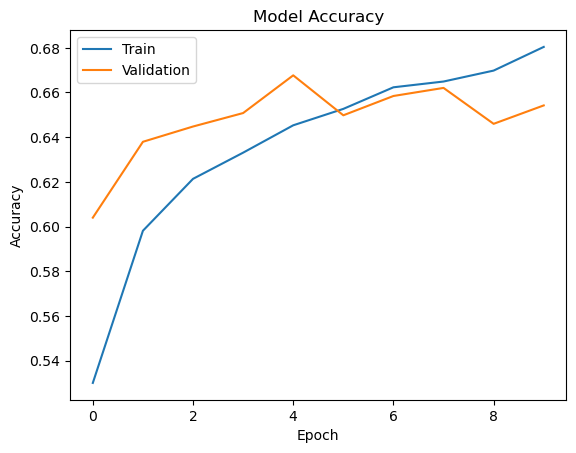


Evaluate model with test data set
4/4 - 1s - 231ms/step - accuracy: 0.7109 - loss: 0.7653

Predict using a model with test data set
4/4 ━━━━━━━━━━━━━━━━━━━━ 2s 260ms/step

Classification Report:
              precision    recall  f1-score   support

           0       0.88      0.72      0.79        32
           1       0.54      0.78      0.64        32
           2       0.74      0.53      0.62        32
           3       0.79      0.81      0.80        32

    accuracy                           0.71       128
   macro avg       0.74      0.71      0.71       128
weighted avg       0.74      0.71      0.71       128


Confusion Matrix:
[[23  6  1  2]
 [ 1 25  4  2]
 [ 0 12 17  3]
 [ 2  3  1 26]]

Heatmap of Confusion Matrix:


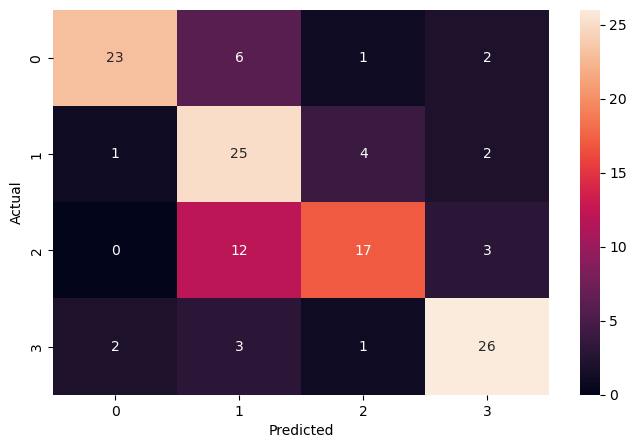

accuracy rate for class happy is 71.9%
accuracy rate for class neutral is 78.1%
accuracy rate for class sad is 53.1%
accuracy rate for class surprise is 81.2%


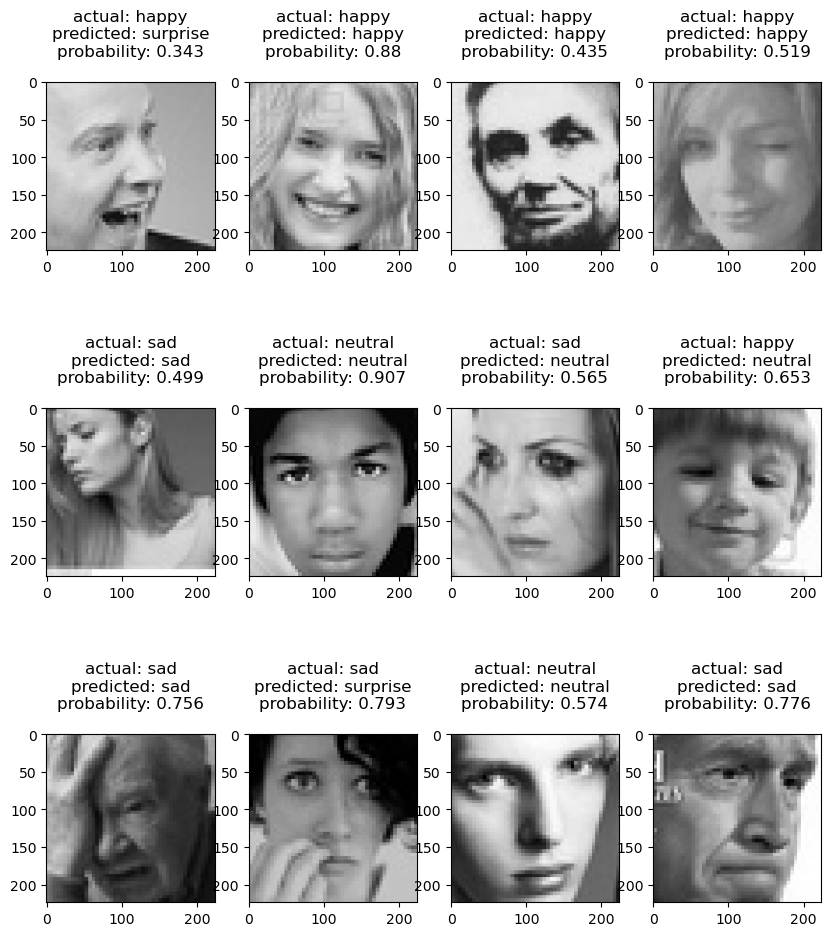

In [32]:
display_model_accuracy(history_c)
evaluate_model(test_set_224_c, eff_model, "rgb")

**Observations and Insights:__**

**Note: You can even go back and build your own architecture on top of the VGG16 Transfer layer and see if you can improve the performance.**

**Think About It:**

* What is your overall performance of these Transfer Learning Architectures? Can we draw a comparison of these models' performances. Are we satisfied with the accuracies that we have received?
* Do you think our issue lies with 'rgb' color_mode?

Now that we have tried multiple pre-trained models, let's build a complex CNN architecture and see if we can get better performance.

## **Building a Complex Neural Network Architecture**

In this section, we will build a more complex Convolutional Neural Network Model that has close to as many parameters as we had in our Transfer Learning Models. However, we will have only 1 input channel for our input images.

## **Creating our Data Loaders**

In this section, we are creating data loaders which we will use as inputs to the more Complicated Convolutional Neural Network. We will go ahead with color_mode = 'grayscale'.

In [33]:
# The data was already loaded and there is no need to reload. 
#
# train_set_g, validation_set_g, test_set_g will be used

### **Model Building**

- Try building a layer with 5 Convolutional Blocks and see if performance increases.

In [34]:
def build_cnn_model_3(color_mode):

    # Create sequential model
    model = Sequential()

    # Define input shape
    if color_mode == "grayscale":
        input_shape = (48, 48, 1)  
    elif color_mode == "rgb":
        input_shape = (48, 48, 3)  

    # first convolutional layer with 16 filters, kernel size of 3x3, 'same' padding, and input shape
    model.add(Conv2D(filters=16, kernel_size=(3, 3), padding='same', input_shape=input_shape))

    # add a LeakyRelu layer with the slope equal to 0.1
    model.add(LeakyReLU(alpha=0.1))

    # second convolutional layer with 32 filters, kernel size of 3x3, and 'same' padding
    model.add(Conv2D(32, (3, 3), padding='same'))

    # add another LeakyRelu with the slope equal to 0.1
    model.add(LeakyReLU(alpha=0.1))

    # add max pooling layer with pool size of 2x2
    model.add(MaxPooling2D(pool_size=(2, 2)))

    # add batch normalization layer
    model.add(BatchNormalization())

    # third convolutional layer with 32 filters, kernel size of 3x3, and 'same' padding
    model.add(Conv2D(32, (3, 3), padding='same'))
    model.add(LeakyReLU(alpha=0.1))

    # fourth convolutional layer with 64 filters, kernel size of 3x3, and 'same' padding
    model.add(Conv2D(64, (3, 3), padding='same'))
    model.add(LeakyReLU(alpha=0.1))

    # add max pooling layer with pool size of 2x2
    model.add(MaxPooling2D(pool_size=(2, 2)))

    # fifth convolutional layer with 32 filters, kernel size of 3x3, and 'same' padding
    model.add(Conv2D(32, (3, 3), padding='same'))

    # add another LeakyRelu with the slope equal to 0.1
    model.add(LeakyReLU(alpha=0.1))

    # add max pooling layer with pool size of 2x2
    model.add(MaxPooling2D(pool_size=(2, 2)))

    # add batch normalization layer
    model.add(BatchNormalization())

    # flatten the output from the previous layer
    model.add(Flatten())

    # add a dense layer with 32 nodes
    model.add(Dense(32))
    model.add(LeakyReLU(alpha=0.1))

    # add a dropout layer with rate 0.5
    model.add(Dropout(0.5))

    # final output layer with nodes equal to the number of classes, i.e., 4 and 'softmax' as the activation function
    model.add(Dense(4, activation='softmax'))

    # compile the model with the loss equal to categorical_crossentropy,
    # optimizer equal to Adam(learning_rate = 0.001), and metric equal to 'accuracy'.
    model.compile(loss='categorical_crossentropy',
                  optimizer=Adam(learning_rate=0.001),
                  metrics=['accuracy'])

    return model



### **Compiling and Training the Model**

In [35]:
# Comple the model
cnn_model_g = build_cnn_model_3("grayscale")
cnn_model_g.summary()

# Fit on the train data and use validation_set_g for validation
history_g = cnn_model_g.fit(train_set_g, 
                            validation_data=validation_set_g, 
                            epochs=30,
                            verbose=1)

c:\Users\lewis.lee\AppData\Local\anaconda3\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:99: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(
c:\Users\lewis.lee\AppData\Local\anaconda3\Lib\site-packages\keras\src\layers\activations\leaky_relu.py:41: UserWarning: Argument `alpha` is deprecated. Use `negative_slope` instead.
  warnings.warn(


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 48, 48, 16)     │           160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu (LeakyReLU)         │ (None, 48, 48, 16)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 48, 48, 32)     │         4,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_1 (LeakyReLU)       │ (None, 48, 48, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 24, 24, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 24, 24, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 24, 24, 32)     │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_2 (LeakyReLU)       │ (None, 24, 24, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 24, 24, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_3 (LeakyReLU)       │ (None, 24, 24, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 12, 12, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 12, 12, 32)     │        18,464 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_4 (LeakyReLU)       │ (None, 12, 12, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 6, 6, 32)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 6, 6, 32)       │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 1152)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 32)             │        36,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_5 (LeakyReLU)       │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 4)              │           132 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 88,292 (344.89 KB)

 Trainable params: 88,164 (344.39 KB)

 Non-trainable params: 128 (512.00 B)

Epoch 1/30
119/119 ━━━━━━━━━━━━━━━━━━━━ 80s 623ms/step - accuracy: 0.3589 - loss: 1.4185 - val_accuracy: 0.3514 - val_loss: 1.3856
Epoch 2/30
119/119 ━━━━━━━━━━━━━━━━━━━━ 31s 250ms/step - accuracy: 0.5007 - loss: 1.1393 - val_accuracy: 0.4882 - val_loss: 1.2114
Epoch 3/30
119/119 ━━━━━━━━━━━━━━━━━━━━ 29s 235ms/step - accuracy: 0.5393 - loss: 1.0645 - val_accuracy: 0.5690 - val_loss: 1.0242
Epoch 4/30
119/119 ━━━━━━━━━━━━━━━━━━━━ 31s 248ms/step - accuracy: 0.5765 - loss: 0.9843 - val_accuracy: 0.5730 - val_loss: 1.0018
Epoch 5/30
119/119 ━━━━━━━━━━━━━━━━━━━━ 38s 310ms/step - accuracy: 0.6120 - loss: 0.9139 - val_accuracy: 0.6261 - val_loss: 0.9049
Epoch 6/30
119/119 ━━━━━━━━━━━━━━━━━━━━ 41s 335ms/step - accuracy: 0.6385 - loss: 0.8555 - val_accuracy: 0.6484 - val_loss: 0.8820
Epoch 7/30
119/119 ━━━━━━━━━━━━━━━━━━━━ 32s 260ms/step - accuracy: 0.6661 - loss: 0.8005 - val_accuracy: 0.6186 - val_loss: 0.9335
Epoch 8/30
119/119 ━━━━━━━━━━━━━━━━━━━━ 30s 244ms/step - accuracy: 0.6891 - loss: 0

### **Evaluating the Model on Test Set**

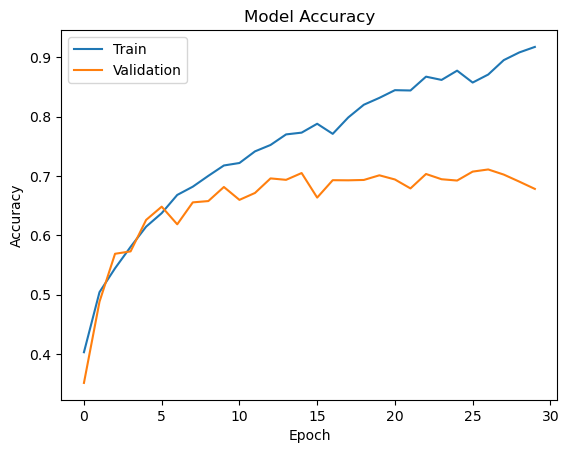

In [36]:
display_model_accuracy(history_g)

**Observations and Insights:__**

### **Plotting the Confusion Matrix for the chosen final model**


Evaluate model with test data set
4/4 - 0s - 13ms/step - accuracy: 0.6953 - loss: 1.2621

Predict using a model with test data set
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step 

Classification Report:
              precision    recall  f1-score   support

           0       0.77      0.62      0.69        32
           1       0.65      0.69      0.67        32
           2       0.55      0.72      0.62        32
           3       0.92      0.75      0.83        32

    accuracy                           0.70       128
   macro avg       0.72      0.70      0.70       128
weighted avg       0.72      0.70      0.70       128


Confusion Matrix:
[[20  4  7  1]
 [ 1 22  9  0]
 [ 2  6 23  1]
 [ 3  2  3 24]]

Heatmap of Confusion Matrix:


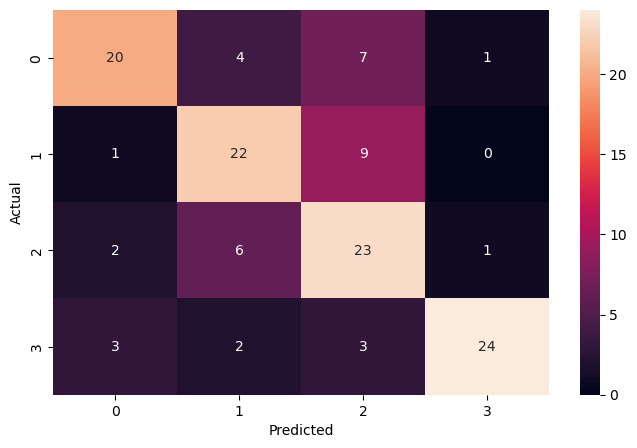

accuracy rate for class happy is 62.5%
accuracy rate for class neutral is 68.8%
accuracy rate for class sad is 71.9%
accuracy rate for class surprise is 75.0%


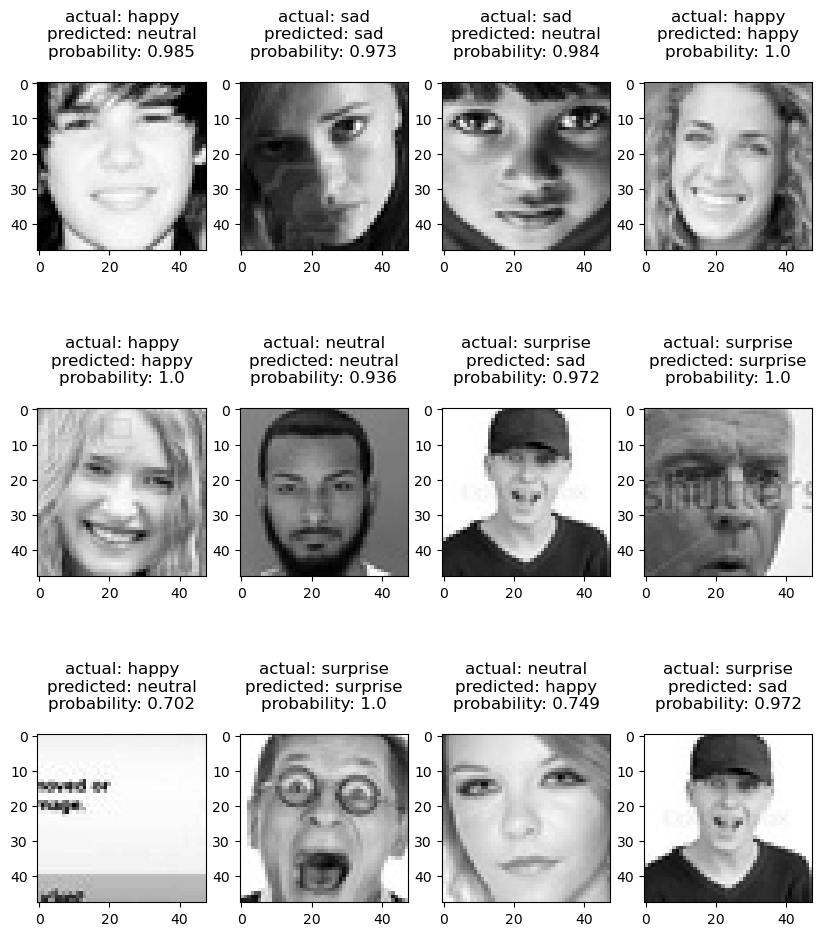

In [37]:
evaluate_model(test_set_g, cnn_model_g, "rgb")

**Observations and Insights:__**

Trial 10 Complete [00h 00m 21s]
val_accuracy: 0.25641026099522907

Best val_accuracy So Far: 0.3333333432674408
Total elapsed time: 00h 02m 03s
{'conv1_filter': 16, 'conv1_kernel': 5, 'conv2_filter': 128, 'conv2_kernel': 3, 'conv2_pool': 2, 'conv3_filter': 128, 'conv3_kernel': 5, 'conv4_filter': 48, 'conv4_kernel': 5, 'conv4_pool': 2, 'conv5_filter': 48, 'conv5_kernel': 3, 'conv5_pool': 3, 'dense_units': 16, 'learning_rate': 0.006759075267307469, 'optimizer': 'sgd'}
Epoch 1/10
119/119 - 138s - 1s/step - accuracy: 0.3452 - loss: 1.3462 - val_accuracy: 0.2729 - val_loss: 1.5270
Epoch 2/10
119/119 - 73s - 612ms/step - accuracy: 0.4036 - loss: 1.2691 - val_accuracy: 0.3980 - val_loss: 1.2492
Epoch 3/10
119/119 - 72s - 607ms/step - accuracy: 0.4384 - loss: 1.2157 - val_accuracy: 0.4302 - val_loss: 1.2052
Epoch 4/10
119/119 - 72s - 601ms/step - accuracy: 0.4753 - loss: 1.1789 - val_accuracy: 0.4888 - val_loss: 1.1424
Epoch 5/10
119/119 - 91s - 766ms/step - accuracy: 0.4976 - loss: 1.1379 - v

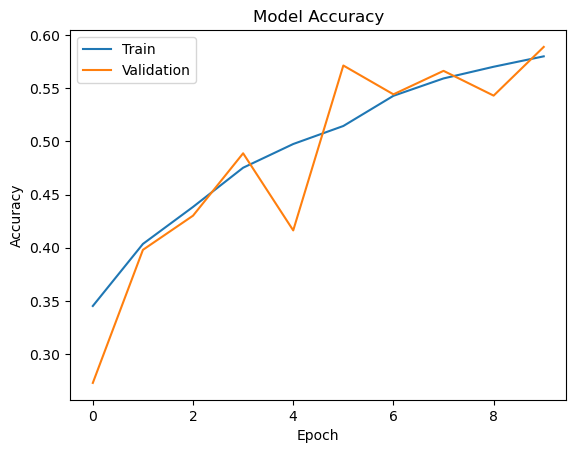


Evaluate model with test data set
4/4 - 0s - 41ms/step - accuracy: 0.6016 - loss: 0.9601

Predict using a model with test data set
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step

Classification Report:
              precision    recall  f1-score   support

           0       0.67      0.56      0.61        32
           1       0.58      0.66      0.62        32
           2       0.43      0.62      0.51        32
           3       1.00      0.56      0.72        32

    accuracy                           0.60       128
   macro avg       0.67      0.60      0.61       128
weighted avg       0.67      0.60      0.61       128


Confusion Matrix:
[[18  3 11  0]
 [ 1 21 10  0]
 [ 4  8 20  0]
 [ 4  4  6 18]]

Heatmap of Confusion Matrix:


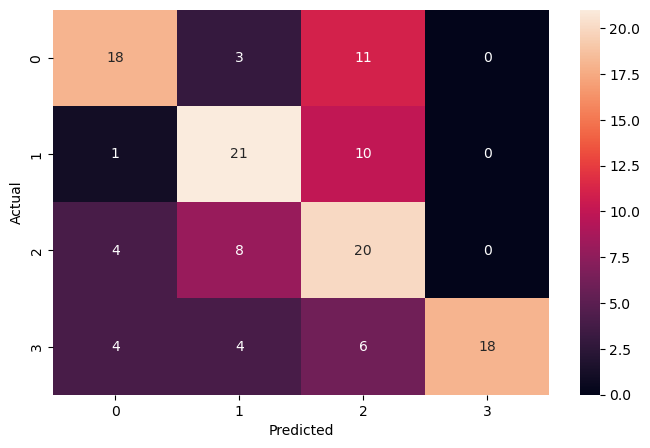

accuracy rate for class happy is 56.2%
accuracy rate for class neutral is 65.6%
accuracy rate for class sad is 62.5%
accuracy rate for class surprise is 56.2%


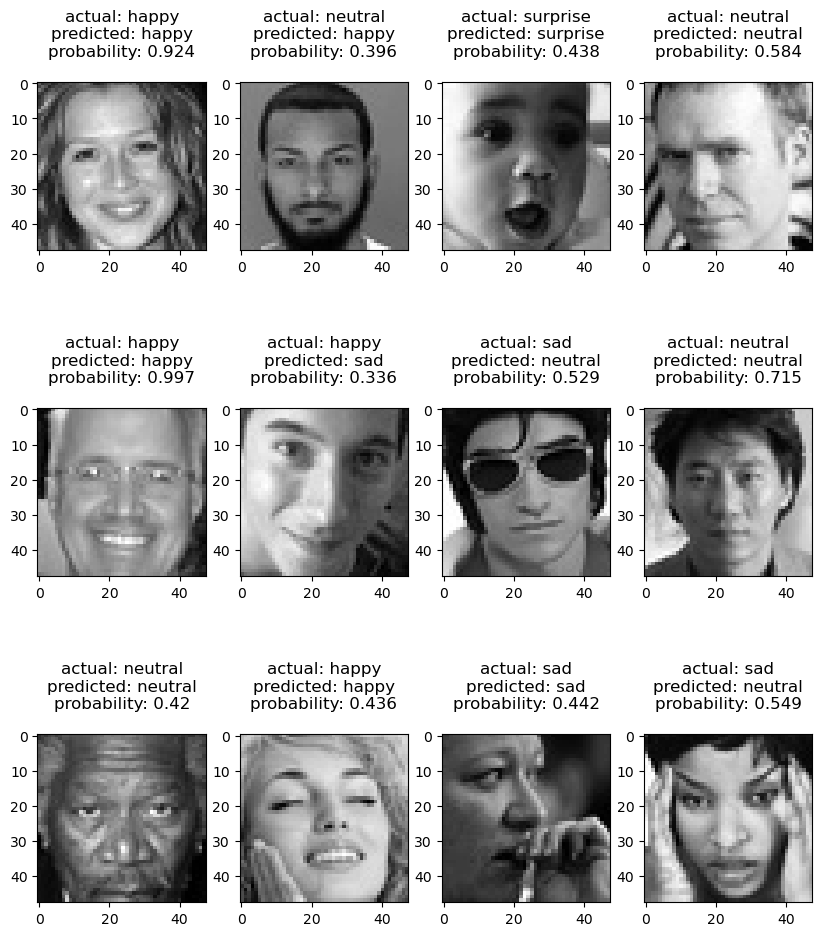

In [43]:
import keras_tuner as kt

# Define the model building function
def build_tuned_model(hp):

    # Create sequential model
    model = Sequential()

    input_shape = (48, 48, 1)  

    # first convolutional layer with 16 filters, kernel size of 3x3, 'same' padding, and input shape
    model.add(Conv2D(filters=hp.Int('conv1_filter', min_value=16, max_value=128, step=16),
                     kernel_size=hp.Choice('conv1_kernel', values=[3, 5]),
                     padding='same',
                     input_shape=input_shape))

    # add a LeakyRelu layer with the slope equal to 0.1
    model.add(LeakyReLU(alpha=0.1))

    # second convolutional layer with 32 filters, kernel size of 3x3, and 'same' padding
    model.add(Conv2D(filters=hp.Int('conv2_filter', min_value=16, max_value=128, step=16),
                     kernel_size=hp.Choice('conv2_kernel', values=[3, 5]),
                     padding='same'))

    # add another LeakyRelu with the slope equal to 0.1
    model.add(LeakyReLU(alpha=0.1))

    # add max pooling layer with pool size of 2x2
    model.add(MaxPooling2D(pool_size=hp.Choice('conv2_pool', values=[2, 3])))

    # add batch normalization layer
    model.add(BatchNormalization())

    # third convolutional layer with 32 filters, kernel size of 3x3, and 'same' padding
    model.add(Conv2D(filters=hp.Int('conv3_filter', min_value=16, max_value=128, step=16),
                     kernel_size=hp.Choice('conv3_kernel', values=[3, 5]),
                     padding='same'))

    model.add(LeakyReLU(alpha=0.1))

    # fourth convolutional layer with 64 filters, kernel size of 3x3, and 'same' padding
    model.add(Conv2D(filters=hp.Int('conv4_filter', min_value=16, max_value=128, step=16),
                     kernel_size=hp.Choice('conv4_kernel', values=[3, 5]),
                     padding='same'))

    model.add(LeakyReLU(alpha=0.1))

    # add max pooling layer with pool size of 2x2
    model.add(MaxPooling2D(pool_size=hp.Choice('conv4_pool', values=[2, 3])))

    # fifth convolutional layer with 32 filters, kernel size of 3x3, and 'same' padding
    model.add(Conv2D(filters=hp.Int('conv5_filter', min_value=16, max_value=128, step=16),
                     kernel_size=hp.Choice('conv5_kernel', values=[3, 5]),
                     padding='same'))

    # add another LeakyRelu with the slope equal to 0.1
    model.add(LeakyReLU(alpha=0.1))

    # add max pooling layer with pool size of 2x2
    model.add(MaxPooling2D(pool_size=hp.Choice('conv5_pool', values=[2, 3])))

    # add batch normalization layer
    model.add(BatchNormalization())

    # flatten the output from the previous layer
    model.add(Flatten())

    # add a dense layer with 32 nodes
    model.add(Dense(units=hp.Int('dense_units', min_value=16, max_value=128, step=16)))
    model.add(LeakyReLU(alpha=0.1))

    # add a dropout layer with rate 0.5
    model.add(Dropout(0.5))

    # final output layer with nodes equal to the number of classes, i.e., 4 and 'softmax' as the activation function
    model.add(Dense(4, activation='softmax'))

    learning_rate = hp.Float("learning_rate", min_value=1e-4, max_value=1e-2, sampling='log')
    optimzer = hp.Choice("optimizer", values=["sgd", "adam"])
    if optimzer == "sgd":
        optimzer = tf.keras.optimizers.SGD(learning_rate=learning_rate)
    else:
        optimzer = tf.keras.optimizers.Adam(learning_rate=learning_rate)

    # compile the model with the loss equal to categorical_crossentropy,
    # optimizer equal to Adam(learning_rate = 0.001), and metric equal to 'accuracy'.
    model.compile(loss='categorical_crossentropy',
                  optimizer=optimzer,
                  metrics=['accuracy'])

    return model

# Instantiate the tuner
tuner = kt.RandomSearch(build_tuned_model,
                        objective='val_accuracy',
                        max_trials=10,
                        executions_per_trial=3,
                        overwrite=True,
                        directory="capstone",
                        project_name="emotion_recognition")

# get a batch of data set for searching best parameters
test_images, test_labels = next(test_set_g)

# Perform hyperparameter tuning
tuner.search(test_images, test_labels, epochs=5, validation_split=0.1)

# Get the best model
best_model = tuner.get_best_models(num_models=1)[0]
best_parameters = tuner.get_best_hyperparameters()
print(best_parameters[0].values)

# Fitting the model
history_g = best_model.fit(train_set_g, 
                           validation_data=validation_set_g, 
                           epochs=10,
                           batch_size=32,
                           validation_split=0.1,
                           verbose=2)

# # get a batch of data set for searching best parameters
# val_images, val_labels = next(validation_set_g)

# # Evaluate the best model on the test set
# loss, accuracy = best_model.evaluate(val_images, val_labels)
# print("Test accuracy:", accuracy)

display_model_accuracy(history_g)
evaluate_model(test_set_g, best_model)


## **Conclusion:____________**

### **Insights**

### **Refined insights**:
- What are the most meaningful insights from the data relevant to the problem?

### **Comparison of various techniques and their relative performance**:
- How do different techniques perform? Which one is performing relatively better? Is there scope to improve the performance further?

### **Proposal for the final solution design**:
- What model do you propose to be adopted? Why is this the best solution to adopt?